# Analysis: Global Evidence on Economic Preferences

* In this class project, you are supposed to work with data from the Global Preferences Survey, a globally representative dataset on risk and time preferences, positive and negative reciprocity, altruism, and trust. <br>
* Further information can be found on the website (https://gps.iza.org/) and in the paper "Global Evidence on Economic Preferences" by Falk, Becker, Dohmen, Enke, Huffman, and Sunde, published in The Quarterly Journal of Economics* 133(4): 1645–1692, 2018 (https://doi.org/10.1093/qje/qjy013).


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from folium import GeoJson, GeoJsonTooltip, LayerControl
import branca.colormap as cm
import folium
import country_converter as coco
from scipy.stats import f_oneway
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pointbiserialr
from matplotlib.patches import Patch
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.stats import gaussian_kde
from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import shap
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/classproject/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Handling
The basis of our work will be the dataset containing information on and preferences of individuals (`individual_new.csv`):
- *country*: Country name
- *isocode*: Three-letter country codes ISO 3166-1 alpha-3
- *ison*: Three-digit country codes ISO 3166-1 numeric
- *region*: Subnational region of interview
- *language*: Interview language
- *date*: Interview date
- *id*: Respondent ID
- *wgt*: Sampling weight of the observation
- *patience*: Level of patience
- *risktaking*: Willingness to take risks
- *posrecip*: Positive reciprocity
- *negrecip*: Negative reciprocity
- *altruism*: Level of altruism
- *trust*: Level of trust
- *subj_math_skills*: Subjective math skills from 0 to 10
- *female*: Indicator for female
- *age*: Age

Note that the variables *patience*, *risktaking*, *posrecip*, *negrecip*, *altruism* and *trust* are normalized to mean 0 and standard deviation 1.

In [2]:
data_with_nans = pd.read_csv("individual_new.csv", sep=",")
data_with_nans

country isocode  ison region language       date             id  \
0      Turkey     TUR   792  Adana  Turkish  07 Mar 12  7100800000001   
1      Turkey     TUR   792  Adana  Turkish  08 Mar 12  7100800000002   
2      Turkey     TUR   792  Adana  Turkish  08 Mar 12  7100800000003   
3      Turkey     TUR   792  Adana  Turkish  07 Mar 12  7100800000004   
4      Turkey     TUR   792  Adana  Turkish  07 Mar 12  7100800000005   
...       ...     ...   ...    ...      ...        ...            ...   
80332   Egypt     EGY   818  Aswan   Arabic  22 Nov 12  7400200001196   
80333   Egypt     EGY   818  Aswan   Arabic  22 Nov 12  7400200001197   
80334   Egypt     EGY   818  Aswan   Arabic  22 Nov 12  7400200001198   
80335   Egypt     EGY   818  Aswan   Arabic  22 Nov 12  7400200001199   
80336   Egypt     EGY   818  Aswan   Arabic  22 Nov 12  7400200001200   

            wgt  patience  risktaking  posrecip  negrecip  altruism     trust  \
0      0.271783  0.047176    1.020203  0.594384 -0.367175 -0.139953  1.679754   
1      0.271783 -0.675698    0.387177  0.662234  0.077251 -0.139953  0.950434   
2      0.442259  0.318254    1.020203 -0.000930  0.077251 -0.606967  0.585774   
3      1.423671  0.498972    1.271527  0.959891  0.077251  0.560569  0.585774   
4      0.705356  0.589331    1.122619  1.325398 -0.367175  0.327062  1.679754   
...         ...       ...         ...       ...       ...       ...       ...   
80332  1.293363 -0.675698    1.150581  0.662234  0.373536 -0.451296 -0.143547   
80333  0.759782 -0.548160   -1.697871  0.364577 -0.732848 -0.758613  0.221113   
80334  0.415252 -0.803235   -1.874741 -0.528394  0.521678 -0.139953  0.585774   
80335  1.139673 -1.313386   -0.047083 -0.000930 -0.488991 -0.139953  0.585774   
80336  1.384037 -0.293085    1.110155  0.662234  0.966104 -0.451296  0.221113   

       subj_math_skills  female age  
0                   7.0       1  26  
1                   3.0       1  50  
2                   7.0       1  21  
3                   7.0       0  24  
4                   9.0       0  24  
...                 ...     ...  ..  
80332               5.0       1  39  
80333               5.0       0  28  
80334               5.0       1  45  
80335               7.0       0  27  
80336               4.0       0  20  

[80337 rows x 17 columns]

## Data Overview

The Global Preferences Survey dataset contains **80,337 observations** from individuals across multiple countries, capturing psychological and behavioral preferences alongside demographic information. The data spans interviews conducted primarily in 2012, with respondents ranging from age 15 to 99+.

**Key Features:**
- **Geographic Coverage:** Multiple countries with ISO codes, regions, and interview languages
- **Preference Measures:** Six standardized psychological traits (patience, risk-taking, reciprocity, altruism, trust) normalized to mean 0, standard deviation 1
- **Demographics:** Age, gender (54% female), and subjective math skills (0-10 scale)
- **Sampling:** Weighted observations to ensure representativeness

The dataset enables analysis of how individual preferences vary across cultures, demographics, and geographic regions, providing a foundation for both descriptive analysis and predictive modeling of human behavioral patterns globally.

For the further analysis, we want to add an additional column 'continent' to the dataset, which contains the continent of the country. <br>

In [3]:
data_with_nans['continent'] = coco.convert(names=data_with_nans['isocode'], to='Continent_7')

### Missing Values Analysis

The dataset contains **80,337 observations** with varying amounts of missing data across variables:





In [4]:
# Insert your code here.
# check if nan in data
data_with_nans.isna().sum()

country                0
isocode                0
ison                   0
region              1008
language               0
date                 515
id                     0
wgt                    0
patience             607
risktaking           634
posrecip             148
negrecip            1801
altruism             434
trust               1563
subj_math_skills    1126
female                 0
age                  276
continent              0
dtype: int64

**Missing Data Pattern:**
- **No missing values:** Country identifiers (`country`, `isocode`, `ison`), demographic core (`id`, `wgt`, `female`), and derived `continent`
- **Minimal missing:** `posrecip` (148), `altruism` (434), `date` (515), `patience` (607), `risktaking` (634)
- **Moderate missing:** `region` (1,008), `subj_math_skills` (1,126), `trust` (1,563) 
- **High missing:** `negrecip` (1,801)

**Key Observations:**
- **Core preference measures** are relatively complete (< 1% missing for most)
- **Negative reciprocity** has the highest missingness (2.2%), potentially indicating measurement challenges
- **Regional data** gaps may reflect administrative/coding issues rather than systematic non-response
- **Age** missing for only 276 respondents (0.3%), suggesting good demographic coverage

## Data Imputation Strategy

The `impute_missing_values` function below implements a dual-purpose data handling strategy that allows us to conduct both exploratory analysis on complete cases and machine learning on the full dataset:

### Function Overview

**Purpose:** Handle missing values systematically while preserving data integrity for different analytical approaches

**Key Features:**
- **Imputation Flags:** Creates boolean indicators (`_imputed` columns) to track which values were imputed
- **Type-Aware Imputation:** Uses different strategies based on data type:
    - **Numeric columns:** Mean imputation
    - **Categorical columns:** Mode imputation (most frequent value)
    - **Datetime columns:** Mode imputation with proper conversion handling

### Dual Analysis Strategy

1. **Exploratory Analysis:** Uses `data` (complete cases only) for:
     - Correlation analysis
     - Visualization
     - Statistical tests
     - Ensures clean, unbiased results from actual observations

2. **Machine Learning:** Uses `data_imputed` (full dataset) for:
     - Maximum sample size preservation
     - Imputation flags as additional features
     - Model performance evaluation considering missing data patterns


In [5]:
def impute_missing_values(df, skip_cols=[]):
    """
    Impute missing values using sklearn's SimpleImputer and create imputation flags.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame with missing values
    skip_cols : list
        Columns to skip during imputation
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with imputed values and imputation flags
    """
    data_imputed = df.copy()
    
    # Create imputation flags for all columns except skip_cols
    for col in data_imputed.columns:
        if col not in skip_cols and not col.endswith('_imputed'):
            data_imputed[f"{col}_imputed"] = data_imputed[col].isna()
    
    # Separate columns by type for different imputation strategies
    numeric_cols = data_imputed.select_dtypes(include=[np.number]).columns.difference(skip_cols)
    categorical_cols = data_imputed.select_dtypes(include=['object', 'category']).columns.difference(skip_cols)
    datetime_cols = data_imputed.select_dtypes(include=['datetime64']).columns.difference(skip_cols)
    
    # Impute numeric columns with mean
    if len(numeric_cols) > 0:
        numeric_imputer = SimpleImputer(strategy='mean')
        data_imputed[numeric_cols] = numeric_imputer.fit_transform(data_imputed[numeric_cols])
    
    # Impute categorical columns with most frequent value
    if len(categorical_cols) > 0:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        data_imputed[categorical_cols] = categorical_imputer.fit_transform(data_imputed[categorical_cols])
    
    # Impute datetime columns with most frequent value
    if len(datetime_cols) > 0:
        datetime_imputer = SimpleImputer(strategy='most_frequent')
        # Convert datetime to string for imputation, then back to datetime
        for col in datetime_cols:
            temp_values = data_imputed[col].astype(str)
            temp_values = datetime_imputer.fit_transform(temp_values.values.reshape(-1, 1)).flatten()
            data_imputed[col] = pd.to_datetime(temp_values)
    
    # Print imputation summary
    imputation_flags = data_imputed.filter(like='_imputed')
    print("Imputation Summary:")
    print("=" * 40)
    for col in imputation_flags.columns:
        count = imputation_flags[col].sum()
        if count > 0:
            original_col = col.replace('_imputed', '')
            print(f"{original_col}: {count} values imputed")
    
    return data_imputed

# Call the function
data_imputed = impute_missing_values(data_with_nans, skip_cols=['country', 'isocode', 'ison', 'language', 'id', 'wgt', 'female', 'continent'])

Imputation Summary:
region: 1008 values imputed
date: 515 values imputed
patience: 607 values imputed
risktaking: 634 values imputed
posrecip: 148 values imputed
negrecip: 1801 values imputed
altruism: 434 values imputed
trust: 1563 values imputed
subj_math_skills: 1126 values imputed
age: 276 values imputed



The `filter_non_imputed_rows` function systematically isolates complete cases from our dataset, enabling robust exploratory analysis on observations without missing values while maintaining data integrity for different analytical approaches.


In [6]:
def filter_non_imputed_rows(df):
    """
    Filter rows that have no missing values (non-imputed rows) and return indices.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with imputation flags
    verbose : bool
        Whether to print summary information
        
    Returns:
    --------
    pandas.Index
        - Index of non-imputed rows for later filtering
    """
    # Get all imputation flag columns
    imputation_flags = df.filter(like='_imputed')
    
    # Create a mask for rows where all imputation flags are False (no missing values)
    no_missing_mask = ~imputation_flags.any(axis=1)
    
    # Get the indices of non-imputed rows
    non_imputed_indices = df.index[no_missing_mask]

    print(f"Number of non-imputed rows: {len(non_imputed_indices)} (out of {len(df)} total rows -> {len(non_imputed_indices) / len(df) * 100:.2f}%)")
    
    return non_imputed_indices

non_imputed_indices = filter_non_imputed_rows(data_imputed)

Number of non-imputed rows: 74701 (out of 80337 total rows -> 92.98%)


## Data Type Issues Identified

Looking at the data structure, we can see several variables that need proper data type conversion:





In [7]:
data_with_nans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80337 entries, 0 to 80336
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           80337 non-null  object 
 1   isocode           80337 non-null  object 
 2   ison              80337 non-null  int64  
 3   region            79329 non-null  object 
 4   language          80337 non-null  object 
 5   date              79822 non-null  object 
 6   id                80337 non-null  int64  
 7   wgt               80337 non-null  float64
 8   patience          79730 non-null  float64
 9   risktaking        79703 non-null  float64
 10  posrecip          80189 non-null  float64
 11  negrecip          78536 non-null  float64
 12  altruism          79903 non-null  float64
 13  trust             78774 non-null  float64
 14  subj_math_skills  79211 non-null  float64
 15  female            80337 non-null  int64  
 16  age               80061 non-null  object

**Key Issues:**
- **`age`**: Currently stored as `object` (string) but should be numeric (`int64`) for analysis
- **`date`**: Stored as `object` but should be `datetime64[ns]` for temporal analysis  
- **Categorical variables**: `country`, `isocode`, `region`, `language`, `continent` would benefit from `category` dtype for memory efficiency and faster operations

**Next Steps:**
We need to clean and convert these variables to their appropriate data types before proceeding with further analysis. This will ensure:
- Proper numerical operations on age
- Correct temporal handling of dates
- Efficient storage and processing of categorical data
- Accurate statistical computations

This will be done in the `change_data_types` function below.

In [8]:
def change_datatypes(data):
    """
    Change the data types of the columns in the DataFrame.
    """
    # Handle age column: replace '99 99+' with '99' before converting to int
    data = data.copy()
    data['age'] = data['age'].replace('99 99+', '99')
    
    # change categorical variables to category type
    data = data.astype({
        "country": "category",
        "language": "category",
        "isocode": "category",
        "region": "category",
        "continent": "category",
        "ison": "float",
        "age": "int64",
        "date": "datetime64[ns]"
    })
    return data


Calling the `change_datatypes` function now cleans the data and converts the variables to their appropriate data types. <br>


In [9]:
data_imputed = change_datatypes(data_imputed)
cols_without_flags = [col for col in data_imputed.columns if not col.endswith('_imputed')]
data_imputed[cols_without_flags].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80337 entries, 0 to 80336
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   country           80337 non-null  category      
 1   isocode           80337 non-null  category      
 2   ison              80337 non-null  float64       
 3   region            80337 non-null  category      
 4   language          80337 non-null  category      
 5   date              80337 non-null  datetime64[ns]
 6   id                80337 non-null  int64         
 7   wgt               80337 non-null  float64       
 8   patience          80337 non-null  float64       
 9   risktaking        80337 non-null  float64       
 10  posrecip          80337 non-null  float64       
 11  negrecip          80337 non-null  float64       
 12  altruism          80337 non-null  float64       
 13  trust             80337 non-null  float64       
 14  subj_math_skills  8033

## Data Standardization

Since all preference variables (`patience`, `risktaking`, `posrecip`, `negrecip`, `altruism`, `trust`) are already normalized to mean 0 and standard deviation 1, but `subj_math_skills` is not standardized, we need to apply standardization to ensure all variables are on the same scale for analysis.

We use `StandardScaler` from sklearn to transform `subj_math_skills` to have mean 0 and standard deviation 1, making it consistent with the other preference measures. 

In [10]:
# standardize subj_math_skills (mean 0 ad std 1)
# Create a StandardScaler instance
scaler = StandardScaler()

# Standardize subj_math_skills (mean 0 and std 1)
data_imputed['subj_math_skills'] = scaler.fit_transform(data_imputed[['subj_math_skills']]).flatten()

Now after standardization, all preference variables are on the same scale, so we can create a variable `preference_columns` that contains all preference measures. This will be useful for further analysis and machine learning tasks.

In [11]:
preference_columns = ['patience', 'risktaking','posrecip','negrecip','altruism','trust','subj_math_skills']

## Correlation Analysis
We analyze correlations between preferences to understand the relationships and patterns in human behavior across different psychological traits. 

**Weighted Correlation Function Explanation**

The `weighted_corr` function computes correlations while accounting for sampling weights, which is crucial for this dataset because different samples have different weights.


In [12]:
def weighted_corr(df, weights):
    cols = df.columns
    X = df.to_numpy()
    w = weights.to_numpy()
    w = w / np.sum(w)  # Normalize weights

    # Weighted mean
    mean = np.average(X, axis=0, weights=w)

    # Center the data
    X_centered = X - mean

    # Apply weights correctly: each row gets its weight
    X_weighted = X_centered * w[:, np.newaxis]  # shape (n_samples, n_features)

    # Weighted covariance
    cov = np.dot(X_weighted.T, X_centered)

    # Standard deviations
    stddev = np.sqrt(np.diag(cov))

    # Compute correlation matrix
    corr = cov / np.outer(stddev, stddev)

    return pd.DataFrame(corr, index=cols, columns=cols)


In [13]:
numerical_columns = data_imputed.select_dtypes(include=[np.number]) \
                        .columns \
                        .difference(['ison', 'date', 'id','wgt','female']) \
                        .tolist()
correlation_matrix = weighted_corr(data_imputed.loc[non_imputed_indices, numerical_columns], data_imputed.loc[non_imputed_indices, "wgt"])
correlation_matrix

age  altruism  negrecip  patience  posrecip  \
age               1.000000 -0.038664 -0.122433 -0.038424  0.004188   
altruism         -0.038664  1.000000  0.049534  0.089810  0.385670   
negrecip         -0.122433  0.049534  1.000000  0.120445 -0.008736   
patience         -0.038424  0.089810  0.120445  1.000000  0.075914   
posrecip          0.004188  0.385670 -0.008736  0.075914  1.000000   
risktaking       -0.223044  0.097889  0.221240  0.201107  0.035351   
subj_math_skills -0.079318  0.110670  0.132788  0.133272  0.109251   
trust             0.056001  0.169791  0.079735  0.061178  0.149469   

                  risktaking  subj_math_skills     trust  
age                -0.223044         -0.079318  0.056001  
altruism            0.097889          0.110670  0.169791  
negrecip            0.221240          0.132788  0.079735  
patience            0.201107          0.133272  0.061178  
posrecip            0.035351          0.109251  0.149469  
risktaking          1.000000          0.156981  0.037918  
subj_math_skills    0.156981          1.000000  0.169355  
trust               0.037918          0.169355  1.000000

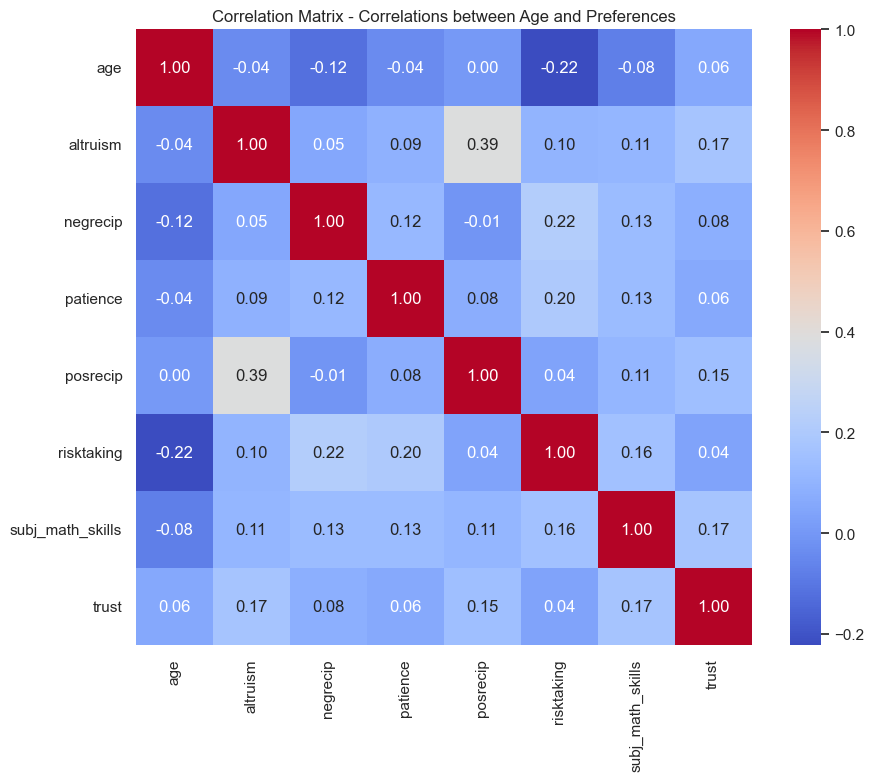

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix - Correlations between Age and Preferences")
plt.show()

This heatmap shows the correlation between age and preferences, as well as the correlation between preferences for individuals. The values range from -1 to 1, where -1 indicates a perfect negative correlation, 0 indicates no correlation, and 1 indicates a perfect positive correlation.

**Key Insights:**

*Correlations that are greater than 0.1 and less than 0.3 indicate a weak correlation:*
* There is a small negative correlation between age and risk-taking (-0.22), which indicates that older people are less likely to take risks.
* There is a small negative correlation between negative reciprocity and age (-0.12), which indicates that older people are less likely to exhibit negative reciprocity.
* There is a small positive correlation between negative reciprocity and risktaking (0.22), which indicates that individuals who are more likely to take risks are also more likely to exhibit negative reciprocity.

*Correlations that are greater than 0.3 and less than 0.5 indicate a moderate correlation:*
* There is a moderate positive correlation between altruism and positive reciprocity (0.39), indicating that individuals who are more altruistic are also more likely to exhibit positive reciprocity, meaning they are more likely to reciprocate positive actions of others.



The `analyze_correlations` function computes and visualizes Pearson correlations between specified variable pairs, creating scatter plots with regression lines and detailed statistical output. It calculates correlation coefficients, p-values, and R² values for each pair, then displays the results in a grid of subplots along with a comprehensive statistical summary table.

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_7143/218569445.py:87: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/opt/miniconda3/envs/classproject/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


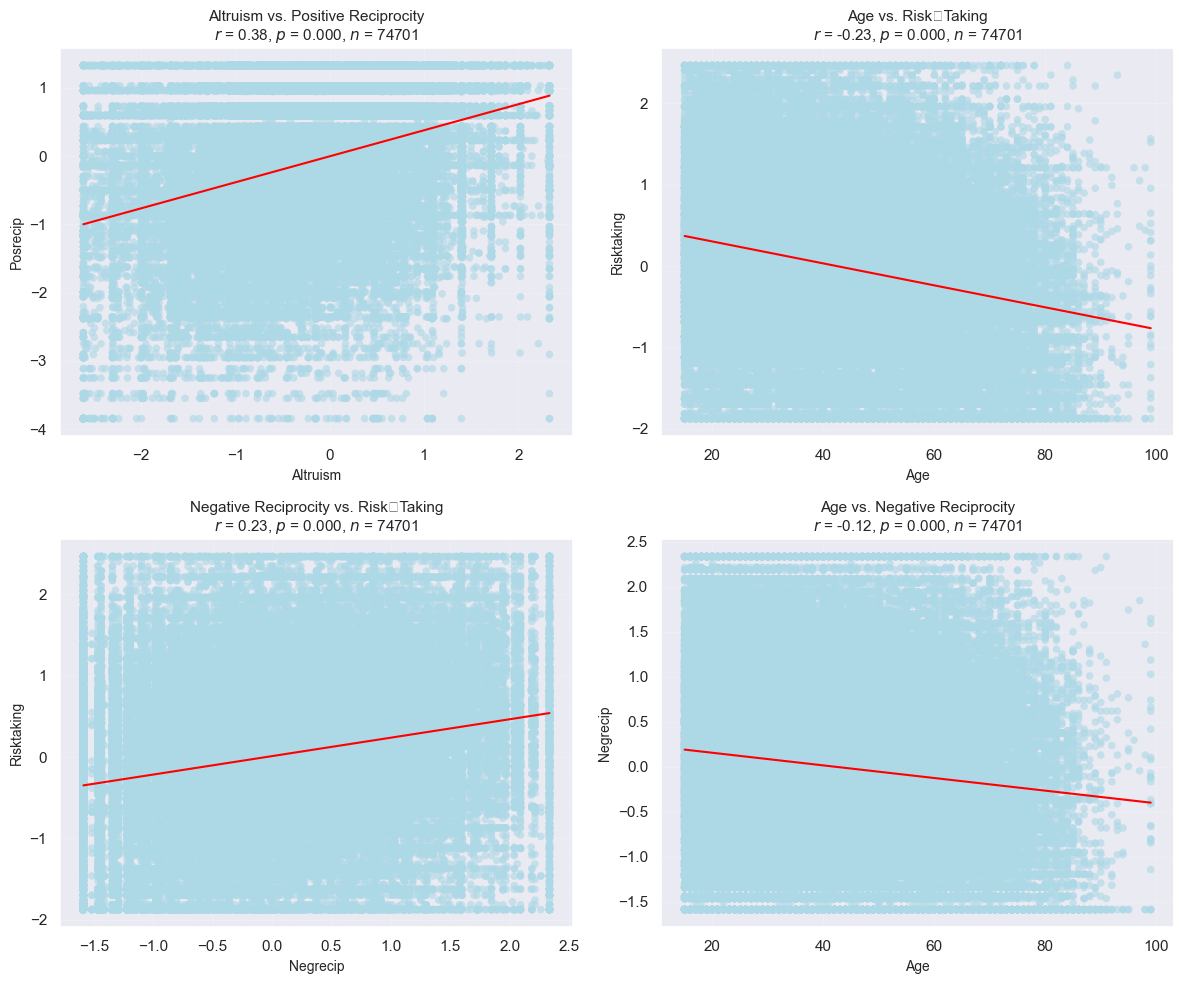


Detailed Correlation Analysis:
Variable Pair                            r        p-value    R²       n      Interpretation
Altruism vs. Positive Reciprocity          0.379    0.0000***   0.144 74701 Moderate correlation
Age vs. Risk‑Taking                       -0.234    0.0000***   0.055 74701 Weak correlation
Negative Reciprocity vs. Risk‑Taking       0.226    0.0000***   0.051 74701 Weak correlation
Age vs. Negative Reciprocity              -0.122    0.0000***   0.015 74701 Weak correlation

Significance: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant

Notes:
- R² indicates the proportion of variance explained (0–1).
- Weak correlations often have a lot of scatter ("noise").
- Outliers can substantially influence correlation estimates.



In [15]:
def analyze_correlations(data, indices, weight_col='wgt', pairs=None, figsize=(12, 10)):
    """
    Analyze and visualize correlations between specific variable pairs.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset containing the variables to analyze
    indices : pandas.Index
        Indices of rows to include in the analysis
    weight_col : str, default='wgt'
        Column name containing sample weights
    pairs : list of tuples, optional
        List of (x_var, y_var, title) tuples. If None, uses default pairs.
    figsize : tuple, default=(12, 10)
        Figure size for the plot
    
    Returns:
    --------
    dict : Dictionary containing correlation statistics for each pair
    """
    
    # Default pairs if none provided
    if pairs is None:
        pairs = [
            ("altruism", "posrecip", "Altruism vs. Positive Reciprocity"),
            ("age", "risktaking", "Age vs. Risk‑Taking"),
            ("negrecip", "risktaking", "Negative Reciprocity vs. Risk‑Taking"),
            ("age", "negrecip", "Age vs. Negative Reciprocity"),
        ]
    
    # Create subplot grid
    n_pairs = len(pairs)
    rows = int(np.ceil(np.sqrt(n_pairs)))
    cols = int(np.ceil(n_pairs / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_pairs == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    results = {}
    
    for idx, (x, y, title) in enumerate(pairs):
        ax = axes[idx]
        x_vals = data.loc[indices, x]
        y_vals = data.loc[indices, y]

        # Compute Pearson r and p-value
        r, p = stats.pearsonr(x_vals, y_vals)

        # Scatter plot in light blue
        ax.scatter(x_vals, y_vals, alpha=0.6, s=30, color='lightblue', edgecolors='none')

        # Fit and plot regression line in red
        slope, intercept, *_ = stats.linregress(x_vals, y_vals)
        xs = np.linspace(x_vals.min(), x_vals.max(), 100)
        ys = slope * xs + intercept
        ax.plot(xs, ys, color='red', lw=1.5)

        # Annotate title with correlation stats
        ax.set_title(f"{title}\n$r$ = {r:.2f}, $p$ = {p:.3f}, $n$ = {len(x_vals)}", 
                     fontsize=11)

        # Minimal axes labels
        ax.set_xlabel(x.replace('_', ' ').title(), fontsize=10)
        ax.set_ylabel(y.replace('_', ' ').title(), fontsize=10)

        # Light grid for orientation
        ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
        
        # Store results
        results[f"{x}_vs_{y}"] = {
            'r': r,
            'p_value': p,
            'r_squared': r**2,
            'n': len(x_vals),
            'slope': slope,
            'intercept': intercept
        }
    
    # Hide unused subplots
    for idx in range(n_pairs, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\nDetailed Correlation Analysis:")
    print("=" * 80)
    print(f"{'Variable Pair':<40} {'r':<8} {'p-value':<10} {'R²':<8} {'n':<6} {'Interpretation'}")
    print("=" * 80)

    for x, y, title in pairs:
        key = f"{x}_vs_{y}"
        r = results[key]['r']
        p = results[key]['p_value']
        r2 = results[key]['r_squared']
        n = results[key]['n']

        # Interpretation
        if abs(r) < 0.1:
            interp = "Practically none"
        elif abs(r) < 0.3:
            interp = "Weak"
        elif abs(r) < 0.5:
            interp = "Moderate"
        else:
            interp = "Strong"

        # Significance stars
        if p < 0.001:
            stars = "***"
        elif p < 0.01:
            stars = "**"
        elif p < 0.05:
            stars = "*"
        else:
            stars = "n.s."

        print(f"{title:<40} {r:>7.3f} {p:>9.4f}{stars:<1} {r2:>7.3f} {n:>5} {interp} correlation")

    print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant")
    print("""
Notes:
- R² indicates the proportion of variance explained (0–1).
- Weak correlations often have a lot of scatter ("noise").
- Outliers can substantially influence correlation estimates.
""")
    
    return results

# Call the function with your data
correlation_results = analyze_correlations(data_imputed, non_imputed_indices)

* All four variable pairs show statistically significant correlations (p < 0.001). 
* The strongest relationship is between altruism and positive reciprocity (r = 0.38, R² ≈ 0.14), indicating a moderate effect. 
* The other three pairs—age vs. risk‑taking (r = –0.23, R² ≈ 0.06), negative reciprocity vs. risk‑taking (r = 0.23, R² ≈ 0.05), and age vs. negative reciprocity (r = –0.12, R² ≈ 0.02)—are statistically significant but represent small effects. 
* Given our large sample, even small r values are estimated precisely, though their practical impact may be limited.

#### Inter‐Preference Correlations Based on Regional Averages

We will analyse the regional differences in preferences of a given year. For statistical analysis, we will focus on the year 2012, as it has the most data points.

In [16]:
data_imputed['year'] = data_imputed['date'].dt.year

# Filter to get non-imputed indices and year 2012
data_filtered_2012 = data_imputed.loc[non_imputed_indices].copy()
data_filtered_2012 = data_filtered_2012[data_filtered_2012['year'] == 2012]

## Continental Preference Analysis

The dataset reveals striking patterns in how psychological preferences vary across continents, offering insights into cultural and regional differences in human behavior:

In [17]:
def weighted_avg(group):
    d = {}
    for col in preference_columns:
        if group[col].notna().sum() == 0:
            d[col] = np.nan
        else:
            d[col] = np.average(group[col], weights=group['wgt'])
    return pd.Series(d)

In [18]:
# Create the preference data for continent analysis with warnings fixed
avg_pref_by_continent = (data_filtered_2012[['continent'] + preference_columns + ['wgt']] 
                        .groupby('continent', observed=True)
                        .apply(weighted_avg, include_groups=False)
                        .reset_index())

avg_pref_by_continent

continent  patience  risktaking  posrecip  negrecip  altruism  \
0         Africa -0.172425    0.274757 -0.229491 -0.096227 -0.033346   
1           Asia -0.052129    0.026794  0.091702  0.121561  0.127586   
2         Europe  0.203467   -0.129789 -0.008020  0.069039 -0.188399   
3  North America  0.064468   -0.087355 -0.237124 -0.175818 -0.091601   
4        Oceania  0.673235    0.156806  0.074660  0.026238  0.152493   
5  South America -0.161382    0.070532  0.115762 -0.117538  0.071164   

      trust  subj_math_skills  
0 -0.239082         -0.206030  
1  0.121325         -0.095954  
2 -0.010886          0.092519  
3 -0.062914          0.091892  
4  0.299767          0.361738  
5 -0.058068         -0.033380

**Key Continental Patterns:**

**Oceania** emerges as distinctly different from other continents:
- **Highest patience** (0.67) - significantly above all other regions
- **High trust** (0.30) and **subjective math skills** (0.36) 
- **Moderate positive reciprocity** and **altruism**
- Suggests cultures that value long-term thinking and interpersonal confidence

**Europe** shows a balanced profile:
- **Above-average patience** (0.20) and **math skills** (0.09)
- **Lower risk-taking** (-0.13) and **altruism** (-0.19)
- **Moderate negative reciprocity** (0.07)
- Reflects potentially more individualistic, risk-averse societies

**Asia** demonstrates moderate prosociality:
- **Highest altruism** (0.13) and **positive reciprocity** (0.09)
- **High trust** (0.12) but **highest negative reciprocity** (0.12)
- **Balanced risk-taking** and **patience**
- Suggests collectivist tendencies with strong reciprocal norms

**Africa** and **South America** share similar patterns:
- **Lower patience** (both around -0.16) and **higher risk-taking**
- **Lower trust levels** and **math skills**
- **Africa**: Lower altruism (-0.03) and positive reciprocity (-0.23)
- **South America**: Higher altruism (0.07) and positive reciprocity (0.12)

**North America** shows mixed characteristics:
- **Moderate patience** (0.06) and **math skills** (0.09)
- **Lowest positive reciprocity** (-0.24) and **negative reciprocity** (-0.18)
- **Lower risk-taking** (-0.09) and **altruism** (-0.09)
- Potentially reflects individualistic culture with weaker reciprocal norms

These patterns suggest that cultural, economic, and social factors significantly shape human preferences across global regions.

In [19]:
# Group by country and year and compute weighted averages
avg_pref_by_country = (data_filtered_2012[['isocode'] + preference_columns + ['wgt']]
                      .groupby('isocode', observed=True)
                      .apply(weighted_avg, include_groups=False)
                      .reset_index())

avg_pref_by_country

isocode  patience  risktaking  posrecip  negrecip  altruism     trust  \
0      AFG -0.196886    0.129260  0.297961  0.267240  0.187868  0.324915   
1      ARE -0.089432    0.085381  0.079125  0.217701  0.161038  0.511629   
2      ARG -0.218146    0.048398  0.148939 -0.128608  0.038985 -0.207111   
3      AUS  0.673235    0.156806  0.074660  0.026238  0.152493  0.299767   
4      AUT  0.632319   -0.050186  0.166648 -0.048520 -0.046974  0.139993   
..     ...       ...         ...       ...       ...       ...       ...   
70     USA  0.815424    0.141157  0.212469  0.017242  0.402663  0.149405   
71     VEN -0.233023    0.248768  0.043857 -0.198912  0.081218  0.104691   
72     VNM  0.134030    0.036028 -0.338847 -0.072235 -0.200364  0.135680   
73     ZAF  0.056292    0.973838 -0.836766  0.031259 -0.320075 -0.168190   
74     ZWE -0.235991    0.531099 -0.162693 -0.124975 -0.035209 -0.507565   

    subj_math_skills  
0          -0.379637  
1           0.347069  
2          -0.144578  
3           0.361738  
4           0.376745  
..               ...  
70          0.533041  
71          0.216847  
72         -0.083811  
73          0.051893  
74         -0.274028  

[75 rows x 8 columns]

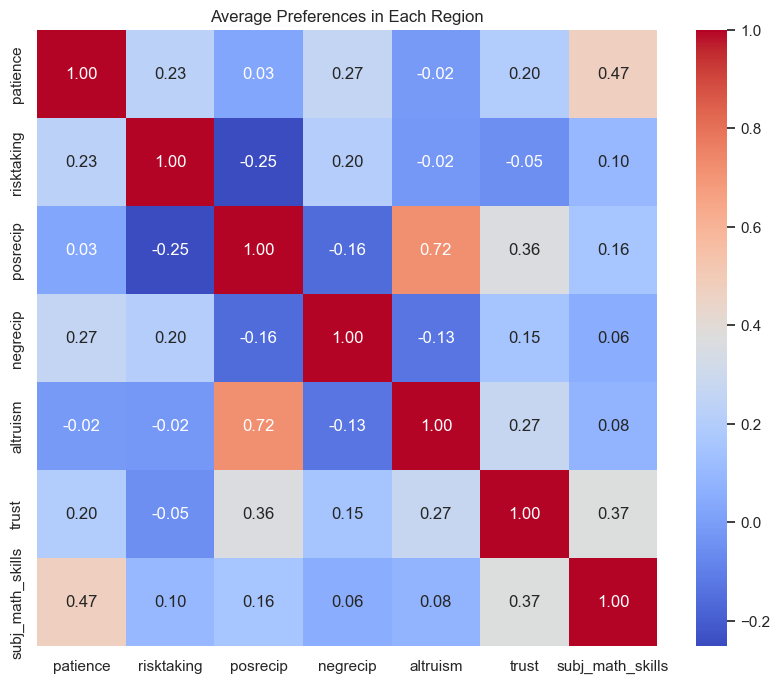


=== Strong Correlations (1 pairs) ===
• posrecip – altruism: r = 0.72

=== Moderate Correlations (3 pairs) ===
• patience – subj_math_skills: r = 0.47
• posrecip – trust: r = 0.36
• trust – subj_math_skills: r = 0.37

=== Weak Correlations (11 pairs) ===
• patience – risktaking: r = 0.23
• patience – negrecip: r = 0.27
• patience – trust: r = 0.20
• risktaking – posrecip: r = -0.25
• risktaking – negrecip: r = 0.20
• risktaking – subj_math_skills: r = 0.10
• posrecip – negrecip: r = -0.16
• posrecip – subj_math_skills: r = 0.16
• negrecip – altruism: r = -0.13
• negrecip – trust: r = 0.15
• altruism – trust: r = 0.27


In [20]:
# Korrelationen der Präferenzen (ohne 'country'-Spalte)
corr_matrix = avg_pref_by_country.drop(columns=['isocode']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Average Preferences in Each Region")
plt.show()

# Buckets for each strength
buckets = {'weak': [], 'moderate': [], 'strong': []}

# Classify each unique pair
for var1, var2 in combinations(corr_matrix.columns, 2):
    r = corr_matrix.loc[var1, var2]
    abs_r = abs(r)
    if 0.1 <= abs_r < 0.3:
        buckets['weak'].append((var1, var2, r))
    elif 0.3 <= abs_r < 0.5:
        buckets['moderate'].append((var1, var2, r))
    elif abs_r >= 0.5:
        buckets['strong'].append((var1, var2, r))
    # else: skip practically none (<0.1)

# Print structured report
for strength in ['strong', 'moderate', 'weak']:
    items = buckets[strength]
    if not items:
        continue
    print(f"\n=== {strength.title()} Correlations ({len(items)} pairs) ===")
    for var1, var2, r in items:
        print(f"• {var1} – {var2}: r = {r:.2f}")



This heatmap shows the correlation between different preferences based on country averages. We measure, for example, whether countries with higher average scores in one preference tend to have higher (or lower) average scores in another preference. This can help identify patterns and relationships between different preferences at a country level.

**Key Insights:**
* positive reciprocity and altruism are strongly positively correlated (0.72), indicating that countries with higher levels of positive reciprocity tend to also have higher levels of altruism.
* patience and subj_math_skills are positively correlated (0.47), indicating that countries with higher patience levels rate their subjective math skills more favorably.
* trust and subj_math skills are positively correlated (0.37), indicating that countries with higher trust levels tend to have better subjective math skills.
* trust and positive reciprocity are weakly positively correlated (0.36), indicating that countries with higher trust levels tend to have higher levels of positive reciprocity.

When we look at the correlations of preferences between different countries vs the correlations of preferences between individuals, we see that the inter-preference correlations are much stronger than the individual correlations. This suggests that preferences are more strongly correlated at the country level than at the individual level. This could be due to cultural differences between countries, which affect the way preferences are formed and expressed.


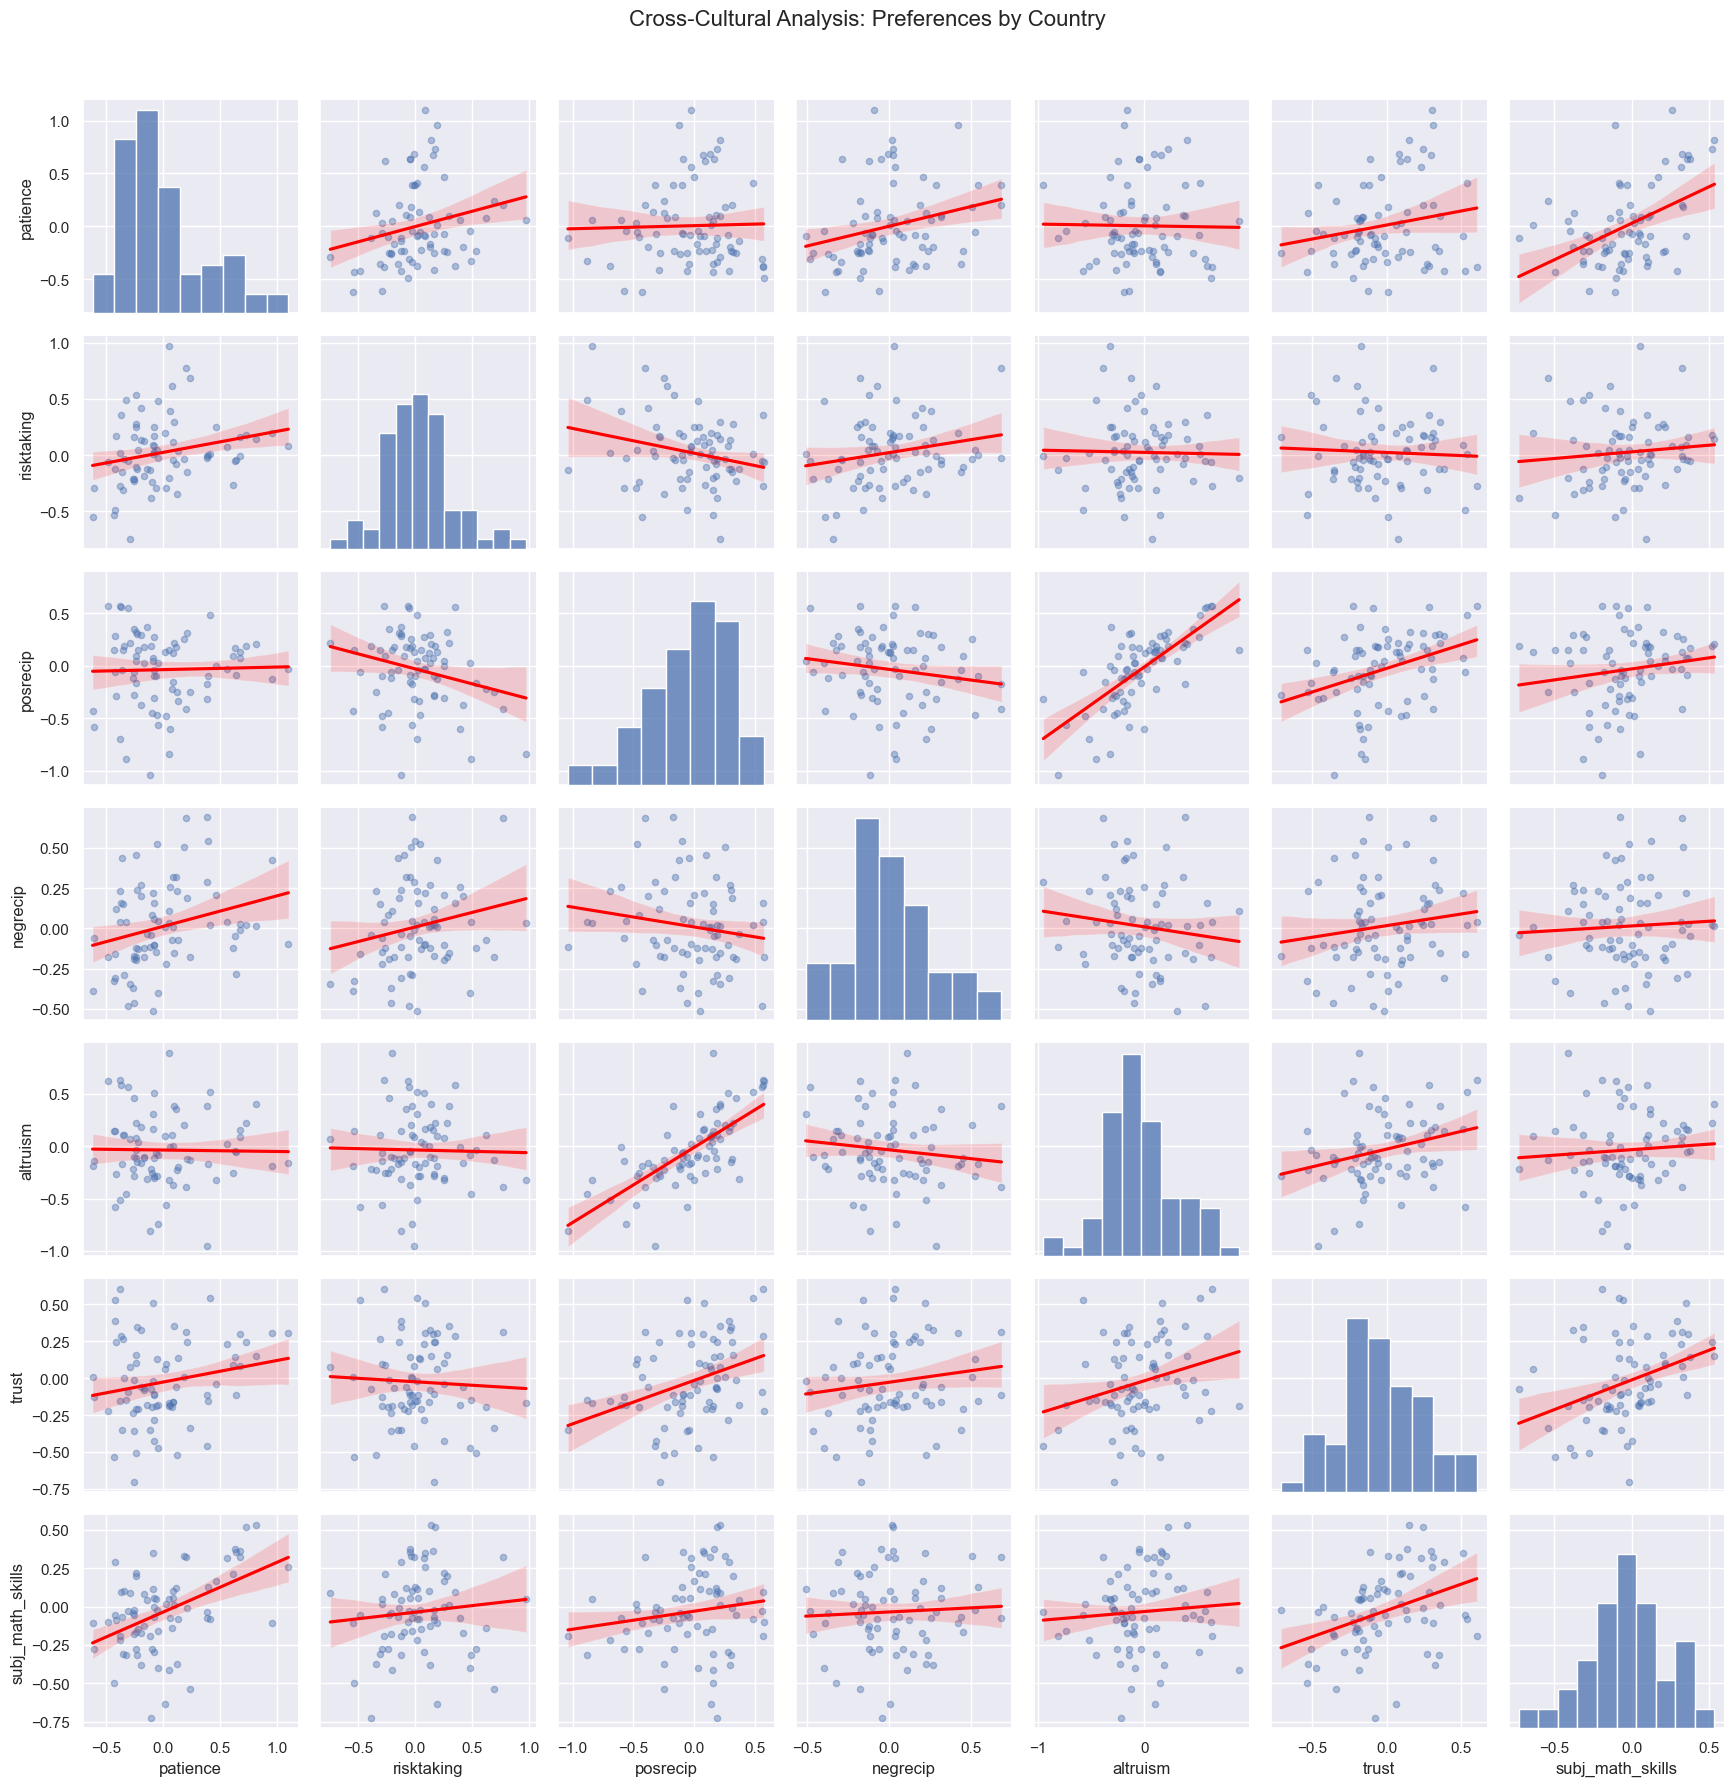

In [21]:
pairs = preference_columns

sns.pairplot(
    data=avg_pref_by_country,
    vars=pairs,
    kind='reg',                                 
    plot_kws={
        'line_kws': {'color': 'red'},           
        'scatter_kws': {'alpha': 0.4, 's': 20}  
    },
    diag_kind='hist'                            
)

plt.suptitle("Cross-Cultural Analysis: Preferences by Country", 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


The cross-cultural analysis plot of preferences by country reveals the following key insights:

* Correlations Between Traits: As already revealed in the correlation analysis, the scatter plots with regression lines suggest positive correlations between certain traits.
    * We can see that posrecip & altruism have a strong positive correlation, as indicated by the upward-sloping red line. That means that countries with higher levels of positive reciprocity tend to also have higher levels of altruism.
    * The same applies to trust & subj math skills, as well as patience and subj math skills.
* The scatter plots show a moderate spread of data points around the regression lines, with confidence intervals (pink shaded areas) indicating that while trends exist, there is still considerable individual or country-level variation.
* The differences in distribution shapes and correlation strengths across traits suggest potential cultural or regional influences on preferences, with some countries showing more pronounced tendencies than others.*

##### Correlations of Country & Preferences

Since regions, country and language are categorical variables, we use the eta coefficient to measure the strength of association with the numerical preference scores.

## Eta Coefficient Function Explanation

The `eta_coefficient` function calculates the **Eta coefficient (η)**, which measures the strength of association between a categorical variable and a numerical variable. This is particularly useful when we want to understand how much a categorical grouping (like country) explains the variance in a continuous outcome (like preferences).

### Why We Use the Eta Coefficient

**Purpose:** The Eta coefficient answers the question: *"How much does knowing someone's category (e.g., country or language) help us predict their numerical score (e.g., patience level)?"*

**Key Advantages:**
- **Handles categorical-numerical relationships** where regular Pearson correlation cannot be used
- **No assumptions about linearity** - captures any relationship pattern between groups
- **Provides interpretable effect sizes** through η² (proportion of variance explained)
- **Statistical significance testing** through ANOVA F-test

### Interpretation

- **η = 0:** No association (knowing the category tells us nothing about the numerical value)
- **η = 1:** Perfect association (category completely determines the numerical value)
- **η² = 0.01:** Small effect (1% of variance explained)
- **η² = 0.06:** Medium effect (6% of variance explained)  
- **η² = 0.14:** Large effect (14% of variance explained)

### Why This Matters for Our Analysis

In our Global Preferences Survey analysis, we use the Eta coefficient to quantify:
- How much **country** explains differences in patience, risk-taking, etc.
- How much **language** influences preference patterns
- Which preferences show the strongest cultural/national clustering

This helps us understand whether individual differences in preferences are primarily personal or shaped by cultural/national context.

In [22]:
def eta_coefficient(categorical_col, numerical_col, df):
    """Calculate Eta coefficient between categorical and numerical variable"""
    groups = [group[numerical_col].dropna() for name, group in df.groupby(categorical_col, observed=True)]
    
    # Remove empty groups
    groups = [group for group in groups if len(group) > 0]
    
    if len(groups) < 2:
        return np.nan, np.nan, np.nan
    
    # F-statistic from ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    # Calculate Eta-squared
    k = len(groups)  
    n = sum(len(group) for group in groups)  
    
    if f_stat * (k-1) + (n-k) == 0:
        return np.nan, np.nan, np.nan
    
    eta_squared = (f_stat * (k-1)) / (f_stat * (k-1) + (n-k))
    eta = np.sqrt(eta_squared)
    
    return eta, eta_squared, p_value

In [23]:
def analyze_country_preferences_eta(data, preference_columns, non_imputed_indices, category_column, show_plots=True, print_results=True):
    """
    Calculate and visualize eta coefficients between a categorical variable and preferences.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset containing categorical and preference data
    preference_columns : list
        List of preference column names to analyze
    non_imputed_indices : pandas.Index
        Indices of non-imputed data to use for analysis
    category_column : str, default 'country'
        Name of the categorical column to analyze against preferences
    show_plots : bool, default True
        Whether to display the visualization plots
    print_results : bool, default True
        Whether to print detailed results
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing eta coefficients, eta squared values, p-values and significance
    """
    
    # Calculate eta coefficients between category and each preference
    eta_coefficients = []
    eta_squared_values = []
    p_values = []

    for pref in preference_columns:
        eta, eta_sq, p_val = eta_coefficient(category_column, pref, data.loc[non_imputed_indices])
        eta_coefficients.append(eta)
        eta_squared_values.append(eta_sq)
        p_values.append(p_val)

    # Create DataFrame for easier handling
    eta_df = pd.DataFrame({
        'preference': preference_columns,
        'eta': eta_coefficients,
        'eta_squared': eta_squared_values,
        'p_value': p_values,
        'significant': np.array(p_values) < 0.05
    })

    if show_plots:
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Bar chart of eta coefficients
        colors = ['#4A90E2' if sig else '#B0C4DE' for sig in eta_df['significant']]
        bars = ax1.bar(range(len(preference_columns)), eta_coefficients, color=colors, alpha=0.7)

        ax1.set_xlabel('Preferences')
        ax1.set_ylabel('Eta Coefficient (η)')
        ax1.set_title(f'Strength of Relationship between {category_column.title()} and Preferences')
        ax1.set_ylim(0, max(eta_coefficients) * 1.25)
        ax1.set_xticks(range(len(preference_columns)))
        ax1.set_xticklabels([pref.replace('_', ' ').title() for pref in preference_columns], 
                           rotation=45, ha='right')
        ax1.grid(True, alpha=0.3, axis='y')

        # Add legend to the bar chart
        legend_elements = [Patch(facecolor='#4A90E2', alpha=0.7, label='Significant (p < 0.05)'),
                          Patch(facecolor='#B0C4DE', alpha=0.7, label='Not Significant')]
        ax1.legend(handles=legend_elements, loc='upper left')

        # Plot 2: Bar chart showing eta-squared (explained variance)
        effect_colors = ['#FF6B6B' if eta_sq >= 0.14 else '#FFA500' if eta_sq >= 0.06 else '#90EE90'
                        for eta_sq in eta_squared_values]
        bars2 = ax2.bar(range(len(preference_columns)), eta_squared_values, color=effect_colors, alpha=0.7)

        ax2.set_xlabel('Preferences')
        ax2.set_ylabel('Eta Squared (η²)')
        ax2.set_title(f'Explained Variance of Preferences by {category_column.title()}')
        ax2.set_ylim(0, max(eta_squared_values) * 1.25)
        ax2.set_xticks(range(len(preference_columns)))
        ax2.set_xticklabels([pref.replace('_', ' ').title() for pref in preference_columns], 
                           rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, axis='y')

        # Add legend for effect sizes
        legend_elements = [Patch(facecolor='#FF6B6B', alpha=0.7, label='Large Effect (η² ≥ 0.14)'),
                          Patch(facecolor='#FFA500', alpha=0.7, label='Medium Effect (0.06 ≤  η² < 0.14)'),
                          Patch(facecolor='#90EE90', alpha=0.7, label='Small Effect (0.01 ≤ η² < 0.06)')]
        ax2.legend(handles=legend_elements, loc='upper left')

        plt.tight_layout()
        plt.show()

    if print_results:
        # Print detailed results
        print(f"Eta Coefficient Results for {category_column.title()}:")
        print("=" * 60)
        print(f"{'Preference':<20} {'η':<8} {'η²':<8} {'p-value':<12} {'Interpretation'}")
        print("-" * 60)

        for i, pref in enumerate(preference_columns):
            significance = "***" if p_values[i] < 0.001 else "**" if p_values[i] < 0.01 else "*" if p_values[i] < 0.05 else ""
            
            # Effect size interpretation
            if eta_squared_values[i] >= 0.14:
                effect = "Large"
            elif eta_squared_values[i] >= 0.06:
                effect = "Medium"
            elif eta_squared_values[i] >= 0.01:
                effect = "Small"
            else:
                effect = "Negligible"
            
            print(f"{pref.replace('_', ' ').title():<20} {eta_coefficients[i]:<8.3f} {eta_squared_values[i]:<8.3f} "
                  f"{p_values[i]:<12.6f} {effect} {significance}")
    
    return eta_df

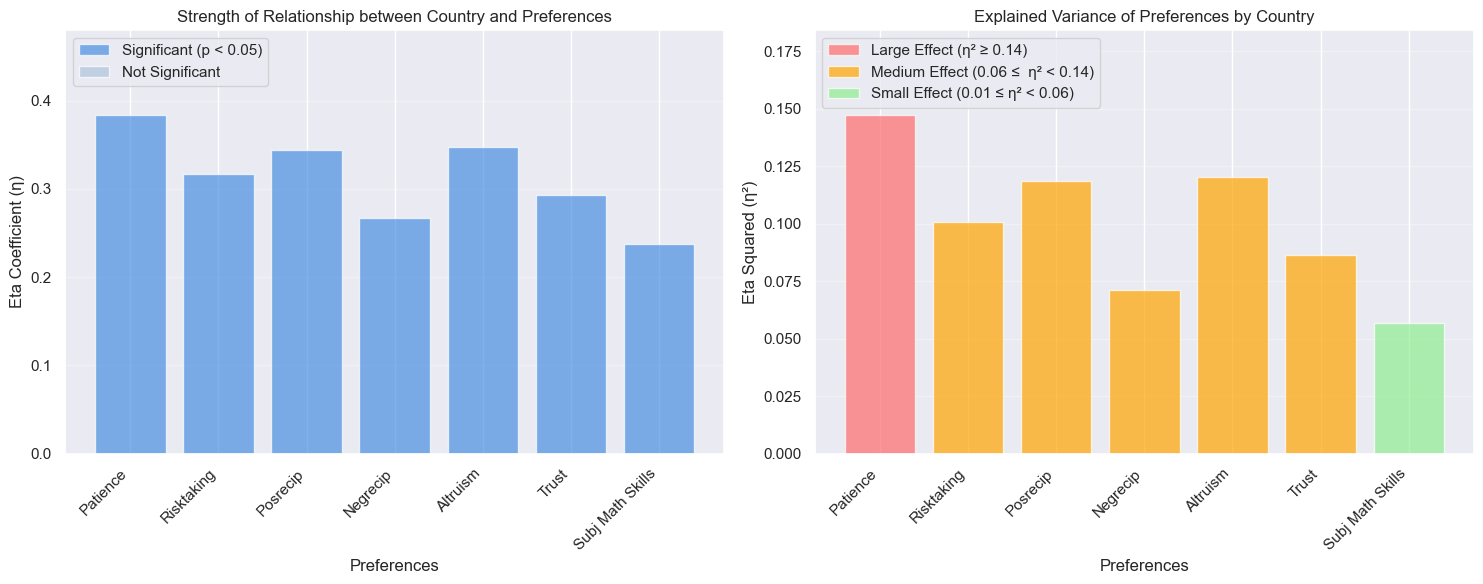

Eta Coefficient Results for Country:
Preference           η        η²       p-value      Interpretation
------------------------------------------------------------
Patience             0.384    0.147    0.000000     Large ***
Risktaking           0.317    0.101    0.000000     Medium ***
Posrecip             0.345    0.119    0.000000     Medium ***
Negrecip             0.267    0.071    0.000000     Medium ***
Altruism             0.347    0.120    0.000000     Medium ***
Trust                0.294    0.086    0.000000     Medium ***
Subj Math Skills     0.238    0.057    0.000000     Small ***


In [24]:
eta_results_country = analyze_country_preferences_eta(
    data_imputed, 
    preference_columns, 
    non_imputed_indices, 
    category_column='country',
    show_plots=True, 
    print_results=True
)

We used the Eta coefficient to quantify how strongly each numeric preference varies by country: first performing a one‑way ANOVA across countries to get an F‑statistic and p‑value, then converting that into η² (the proportion of variance in the preference explained by country) and η = √η² (the strength of the relationship). A significant p‑value (p < .05) indicates that mean preferences differ across at least some countries. η ranges from 0 (no association) to 1 (perfect association), while η² tells you what fraction of total variance is accounted for. We then flagged effects as negligible, small, medium, or large based on conventional η² thresholds.

* Patience (η = .384, η² = .147, p < .001): A large effect—country explains about 14.7% of the variance

* Risk‑taking (η = .317, η² = .101, p < .001): A medium effect—country accounts for 10.1% of differences; some countries are notably more risk‑seeking than others.

* Positive reciprocity (η = .345, η² = .119, p < .001): Medium effect—country explains 11.9% of variance, showing consistent cross‑national patterns in willingness to help those who helped you.

* Negative reciprocity (η = .267, η² = .071, p < .001): Medium effect—country accounts for 7.1% of differences in punitive tendencies; significant but less pronounced.

* Altruism (η = .347, η² = .120, p < .001): Medium effect—12.0% of variance; notable national differences in generosity.

* Subjective math skills (η = .238, η² = .057, p < .001): Small effect—5.7% explained; while significant, country plays a smaller role here.

Overall, all preferences show statistically significant associations with country (p < .001), with effect sizes ranging from small to large—demonstrating that country of residence is indeed correlated with these psychological and behavioral measures.

#### Correlation of Language and Preferences

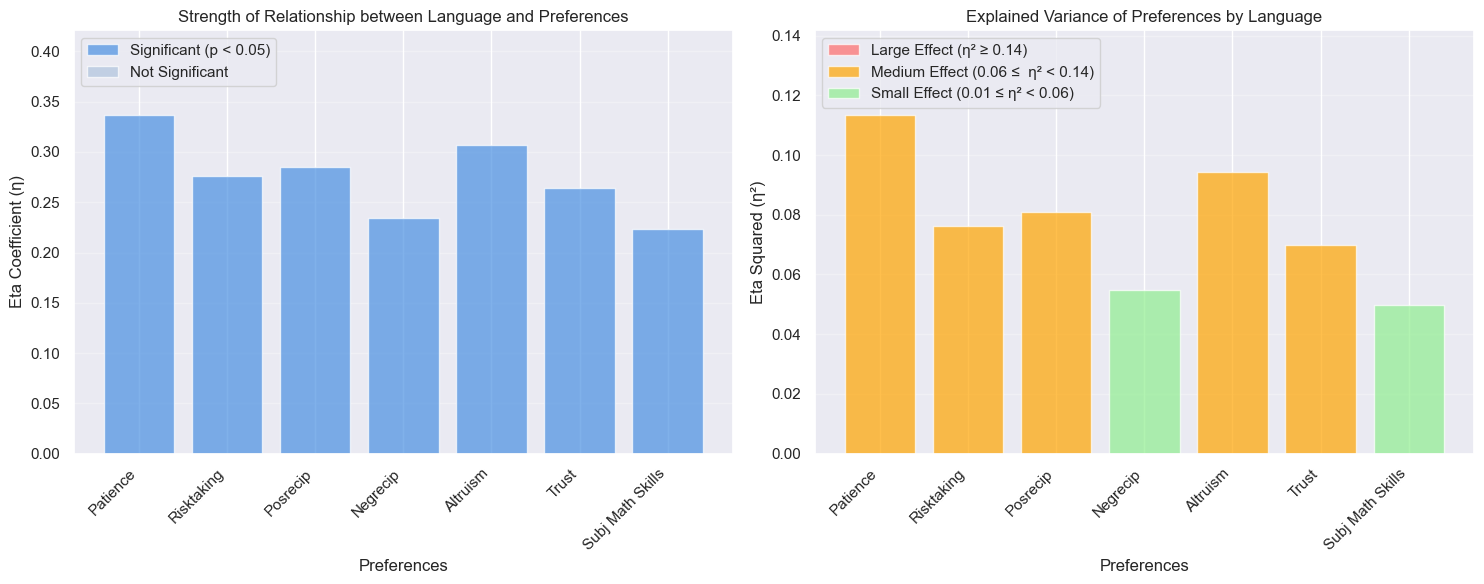

Eta Coefficient Results for Language:
Preference           η        η²       p-value      Interpretation
------------------------------------------------------------
Patience             0.337    0.113    0.000000     Medium ***
Risktaking           0.276    0.076    0.000000     Medium ***
Posrecip             0.285    0.081    0.000000     Medium ***
Negrecip             0.234    0.055    0.000000     Small ***
Altruism             0.307    0.094    0.000000     Medium ***
Trust                0.264    0.070    0.000000     Medium ***
Subj Math Skills     0.223    0.050    0.000000     Small ***


In [25]:
eta_results_language = analyze_country_preferences_eta(
    data_imputed, 
    preference_columns, 
    non_imputed_indices, 
    category_column='language',
    show_plots=True, 
    print_results=True
)

The Eta results for language show that speakers of different languages differ significantly on all seven preference measures (all p < .001), with medium effects for most traits (η² ≈ 0.07–0.11) and small effects for negative reciprocity and subjective math skills (η² ≈ 0.05–0.06). This means language explains roughly 5–11% of the variance in these preferences. Compared to the country analysis, language effects are consistently smaller across the board. Thus, while language matters, it’s less predictive of individual preferences than country of residence.

**Interpretation of Language Effects:**

* Patience (η = .337, η² = .113): Medium effect—about 11.3% of variance; some language groups report substantially higher patience.

* Risk-taking (η = .276, η² = .076): Medium effect—7.6% explained; linguistic background moderately shapes willingness to take risks.

* Positive reciprocity (η = .285, η² = .081): Medium effect—8.1% of differences; language communities vary in their propensity to repay kindness.

* Negative reciprocity (η = .234, η² = .055): Small effect—5.5% explained; less pronounced but still significant cross-linguistic variation in punitive behavior.

* Altruism (η = .307, η² = .094): Medium effect—9.4% of variance; generosity shows moderate linguistic grouping.

* Trust (η = .264, η² = .070): Medium effect—7.0% explained; language correlates moderately with general trust levels.

* Subjective math skills (η = .223, η² = .050): Small effect—5.0% of variance; modest differences in self-assessed math ability by language.

**Country vs. Language:**
* Across all preferences, country effects (η² = ~0.06–0.15) exceed language effects (η² = ~0.05–0.11), so country of residence is a stronger predictor of these preferences than language group.

#### Correlation of Gender and Preferences

Since we cannot calculate regular Pearson correlation between the categorical variable 'female' and continuous preference variables, we use point-biserial correlation for this analysis. The `calculate_pointbiserial_correlations` function computes the point-biserial correlation coefficient between a binary variable (gender) and multiple continuous variables (preferences), which measures the strength and direction of the linear relationship between a dichotomous and continuous variable. This specialized correlation technique allows us to quantify how much preference scores differ between males and females while providing statistical significance testing for each relationship.

In [26]:
def calculate_pointbiserial_correlations(data, binary_col, continuous_cols, indices=None, print_results=True):
    """
    Calculate point-biserial correlations between a binary variable and continuous variables.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The dataset containing binary and continuous variables
    binary_col : str
        Name of the binary column (0/1 coded)
    continuous_cols : list
        List of continuous variable column names to analyze
    indices : pandas.Index, optional
        Indices of data to use for analysis (if None, uses all data)
    print_results : bool, default True
        Whether to print detailed results
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing correlations, p-values and significance
    """
    # Filter data if indices provided
    if indices is not None:
        analysis_data = data.loc[indices]
    else:
        analysis_data = data
    
    # Calculate point-biserial correlations
    correlations = []
    p_values = []
    
    for col in continuous_cols:
        # Handle potential data type issues
        if col == 'subj_math_skills':
            corr, p_val = pointbiserialr(analysis_data[binary_col], analysis_data[col].astype(float))
        else:
            corr, p_val = pointbiserialr(analysis_data[binary_col], analysis_data[col])
        correlations.append(corr)
        p_values.append(p_val)
    
    # Create DataFrame for results
    corr_df = pd.DataFrame({
        'variable': continuous_cols,
        'correlation': correlations,
        'p_value': p_values,
        'significant': np.array(p_values) < 0.05,
        'abs_correlation': np.abs(correlations)
    })
    
    if print_results:
        # Print detailed results
        print(f"Point-Biserial Correlation Results for {binary_col.title()}:")
        print("=" * 60)
        print(f"{'Variable':<20} {'r':<8} {'p-value':<12} {'Significance'}")
        print("-" * 60)
        
        for i, col in enumerate(continuous_cols):
            significance = "***" if p_values[i] < 0.001 else "**" if p_values[i] < 0.01 else "*" if p_values[i] < 0.05 else "n.s."
            print(f"{col.replace('_', ' ').title():<20} {correlations[i]:>7.3f} {p_values[i]:>11.6f} {significance}")
        
        print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant")
        print(f"\nInterpretation for {binary_col.title()} (1 = True, 0 = False):")
        print("- Positive correlations: Higher values when binary variable = 1")
        print("- Negative correlations: Lower values when binary variable = 1")
    
    return corr_df

In [27]:
# Calculate correlations
gender_corr_results = calculate_pointbiserial_correlations(
    data=data_imputed,
    binary_col='female',
    continuous_cols=preference_columns,
    indices=non_imputed_indices,
    print_results=True
)

Point-Biserial Correlation Results for Female:
Variable             r        p-value      Significance
------------------------------------------------------------
Patience              -0.038    0.000000 ***
Risktaking            -0.112    0.000000 ***
Posrecip               0.021    0.000000 ***
Negrecip              -0.085    0.000000 ***
Altruism               0.032    0.000000 ***
Trust                  0.014    0.000110 ***
Subj Math Skills      -0.115    0.000000 ***

Significance: *** p<0.001, ** p<0.01, * p<0.05, n.s. = not significant

Interpretation for Female (1 = True, 0 = False):
- Positive correlations: Higher values when binary variable = 1
- Negative correlations: Lower values when binary variable = 1


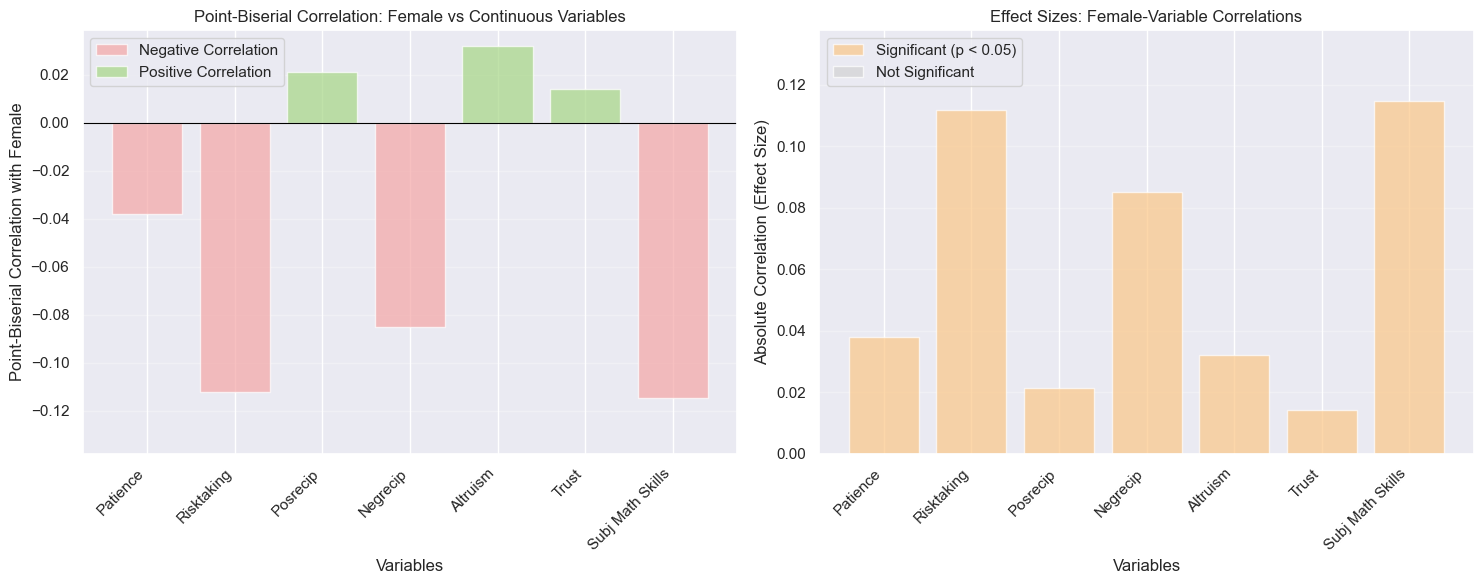

In [28]:
def plot_pointbiserial_correlations(corr_df, binary_col):
    """
    Create visualizations for point-biserial correlation results.
    
    Parameters:
    -----------
    corr_df : pandas.DataFrame
        DataFrame containing correlation results from calculate_pointbiserial_correlations
    binary_col : str
        Name of the binary column for labeling
    """
    
    continuous_cols = corr_df['variable'].tolist()
    correlations = corr_df['correlation'].tolist()
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Bar chart of correlations (showing direction)
    colors = ['#F4A6A6' if corr < 0 else '#A6D785' for corr in correlations]
    bars = ax1.bar(range(len(continuous_cols)), correlations, color=colors, alpha=0.7)
    
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax1.set_xlabel('Variables')
    ax1.set_ylabel(f'Point-Biserial Correlation with {binary_col.title()}')
    ax1.set_title(f'Point-Biserial Correlation: {binary_col.title()} vs Continuous Variables')
    ax1.set_ylim(min(correlations) * 1.2, max(correlations) * 1.2)
    ax1.set_xticks(range(len(continuous_cols)))
    ax1.set_xticklabels([col.replace('_', ' ').title() for col in continuous_cols], 
                       rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add legend for direction
    legend_elements = [Patch(facecolor='#F4A6A6', alpha=0.7, label='Negative Correlation'),
                      Patch(facecolor='#A6D785', alpha=0.7, label='Positive Correlation')]
    ax1.legend(handles=legend_elements, loc='upper left')
    
    # Plot 2: Bar chart showing absolute effect sizes
    effect_colors = ['#FBC787' if sig else 'lightgrey' for sig in corr_df['significant']]
    bars2 = ax2.bar(range(len(continuous_cols)), np.abs(correlations), 
                   color=effect_colors, alpha=0.7)
    
    ax2.set_xlabel('Variables')
    ax2.set_ylabel('Absolute Correlation (Effect Size)')
    ax2.set_title(f'Effect Sizes: {binary_col.title()}-Variable Correlations')
    ax2.set_ylim(0, max(np.abs(correlations)) * 1.2)
    ax2.set_xticks(range(len(continuous_cols)))
    ax2.set_xticklabels([col.replace('_', ' ').title() for col in continuous_cols], 
                       rotation=45, ha='right')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add legend for significance
    legend_elements = [Patch(facecolor='#FBC787', alpha=0.7, label='Significant (p < 0.05)'),
                      Patch(facecolor='lightgrey', alpha=0.7, label='Not Significant')]
    ax2.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()


# Plot the results
plot_pointbiserial_correlations(gender_corr_results, 'female')

* The visualization displays point-biserial correlations between gender (female) and various preference measures through two complementary bar charts. 
* The left chart shows correlation direction and strength, revealing that females tend to have lower risk-taking behavior and subjective math skills (negative correlations), patience and negative reciprocity while showing slightly higher positive reciprocity, altruism, and trust (positive correlations), with the right chart confirming that all relationships are statistically significant despite being generally small in magnitude.

The table summarizes how the different numerical variables are distributed


In [29]:
data_imputed.loc[non_imputed_indices, numerical_columns].describe()

age      altruism      negrecip      patience      posrecip  \
count  74701.000000  74701.000000  74701.000000  74701.000000  74701.000000   
mean      41.468039     -0.001990      0.004529      0.010896     -0.003943   
std       17.330898      0.997632      0.993989      1.006575      1.001861   
min       15.000000     -2.610568     -1.586460     -1.313386     -3.844215   
25%       27.000000     -0.649911     -0.802236     -0.675698     -0.664094   
50%       39.000000      0.034776      0.012864     -0.293085      0.228877   
75%       54.000000      0.696112      0.713107      0.466968      0.730084   
max       99.000000      2.330662      2.333531      2.763126      1.325398   

         risktaking  subj_math_skills         trust  
count  74701.000000      74701.000000  74701.000000  
mean       0.013650          0.004622     -0.003586  
std        0.999014          1.000739      0.997060  
min       -1.874741         -1.845490     -1.966848  
25%       -0.618120         -0.775876     -0.508207  
50%       -0.046999         -0.062800     -0.143547  
75%        0.681961          0.650277      0.585774  
max        2.466159          1.719891      1.679754


**Key Insights**
* **Sample Size:** Sample size: 74 701 observations.
* **Age Distribution:** Mean ≈ 41.5 years, median 39 years. Minimum age: 15, maximum age: 99+ -> we have a wide age range, allowing for diverse perspectives.
* **Gender Distribution:** 54% female, 46% male were interviewed, indicating a balanced representation.
* **Preference Distribution:** Normalized preferences with mean 0 and standard deviation 1. (except for subjective math skills, which is not normalized )

The sample is representative of the global population, with a wide age range and a balanced gender distribution. The preferences are normalized, allowing for direct comparisons across individuals and countries.

## Data Visualization

### Weighted Violin Plot Function

The `create_weighted_violin_plot` function creates violin plots that show the distribution shape of numerical variables while accounting for sampling weights in the Global Preferences Survey data. It uses weighted Kernel Density Estimation (KDE) to ensure that observations with higher sampling weights have proportionally greater influence on the estimated probability density, making the visualizations representative of the actual population rather than just the raw sample. The function applies Min-Max scaling to make variables comparable on the same 0-1 scale and displays quartile lines to provide additional distributional information alongside the smooth density curves.

In [30]:
def create_weighted_violin_plot(data, numerical_columns, indices, weight_col='wgt', figsize=(12, 6)):
    """
    Create a weighted violin plot for numerical columns using KDE.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Input DataFrame (assumed to be already scaled)
    numerical_columns : list
        List of numerical column names to plot
    indices : pandas.Index
        Indices of rows to include in the plot
    weight_col : str, default='wgt'
        Column name containing sample weights
    figsize : tuple, default=(12, 6)
        Figure size for the plot
    """
    data = data.loc[indices, numerical_columns + [weight_col]].copy()

    # Applay min max scaling to numerical columns
    scaler = MinMaxScaler()
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
    
    # Setup
    fig, ax = plt.subplots(figsize=figsize)

    # Loop over numerical columns
    for i, col in enumerate(numerical_columns):
        values = data[col].to_numpy()
        weights = data[weight_col].to_numpy()

        # Compute weighted KDE
        kde = gaussian_kde(values, weights=weights)
        x_vals = np.linspace(values.min(), values.max(), 200)
        y_vals = kde(x_vals)

        # Normalize to scale violin width uniformly
        y_vals = y_vals / y_vals.max() * 0.4

        # Plot the violin (both sides)
        ax.fill_betweenx(x_vals, i - y_vals, i + y_vals, label=col, alpha=0.7)

        # Plot quartiles
        q1, q2, q3 = np.percentile(values, [25, 50, 75])
        ax.plot([i - 0.4, i + 0.4], [q1, q1], color='k', lw=0.75, linestyle=':')  # first quartile
        ax.plot([i - 0.4, i + 0.4], [q2, q2], color='k', lw=0.75, linestyle=':')  # median
        ax.plot([i - 0.4, i + 0.4], [q3, q3], color='k', lw=0.75, linestyle=':')  # third quartile

    # Style the plot
    ax.set_xticks(range(len(numerical_columns)))
    ax.set_xticklabels([col.replace('_', ' ').title() for col in numerical_columns], 
                      rotation=45, ha='right')
    ax.set_ylabel("Value")
    ax.set_title("Weighted Violin Plot of Min-Max Scaled Numerical Variables")
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

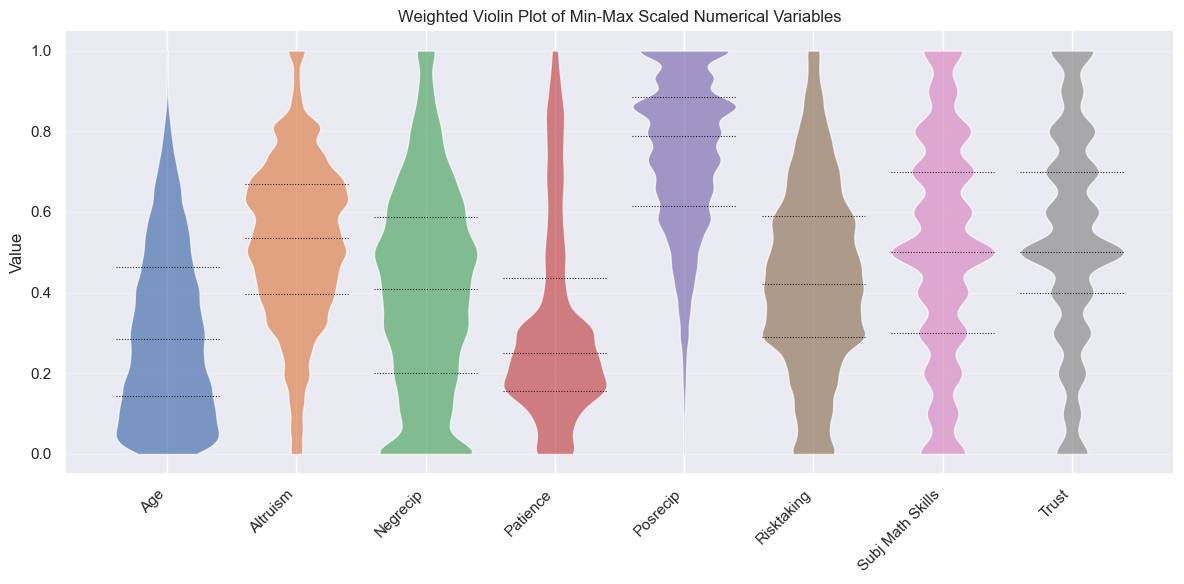

In [31]:
create_weighted_violin_plot(
    data=data_imputed,
    numerical_columns=numerical_columns,
    indices=non_imputed_indices,
    weight_col='wgt',
    figsize=(12, 6)
)


The Global Preferences Survey dataset captures a diverse age range spanning from **15 to 99 years**, with the following key characteristics:


**Weighted Violin Plot — Key Takeaways**

Below is a summary of the key takeaways from the weighted violin plot analysis:

- **Age Distribution**: the age distribution resembles a pyramid with a peak at 0.9 (approximately 0.9*(99-15)=76 years). The average age is around 0.3 scaled, which corresponds to approximately 0.3*(99-15)=24 years. The shape shows that most people that were interviewed were younger than 0.6 scaled, which corresponds to approximately 0.6*(99-15)=50 years.

- **Altruism**: The distribution of altruism shows that most people rate themselves between 0.3 and 0.8, indicating a moderate level of altruism across the sample. Indicating that most people tend to rate themselves as moderately altruistic, with a few individuals rating themselves very high or very low.

- **Negative Reciprocity**: The distribution of negative reciprocity shows that most people rate themselves between 0.2 and 0.6, indicating that most people tend to rate themselves as lower negative reciprocal, with a few individuals rating themselves very high or very low.

- **Patience**: The distribution of patience shows that most people rate themselves between 0.1 and 0.3, indicating that most people tend to rate themselves as lower patient, with a few individuals rating themselves very high or very low.

- **Positive Reciprocity**: The distribution of positive reciprocity shows that most people rate themselves between 0.4 and 1 indicating that most people either rate themselves high in positive reciprocity.

- **Risk-Taking**: The distribution of risk-taking shows that most people rate themselves between 0.2 and 0.6, indicating that most people tend to rate themselves as lower risk-takers, with a few individuals rating themselves very high.

- **Subjective Math Skills** & **Trust**: The distributions of subjectiveub math skills and trust are both characterized by discrete values between 0 and 10. Most people rate themselves at 5, with all other ratings occurring with equal frequency.


We will now analyze the relationship between age and the proportion of female participants in the survey. This analysis aims to uncover any trends or patterns in female representation across different age groups.


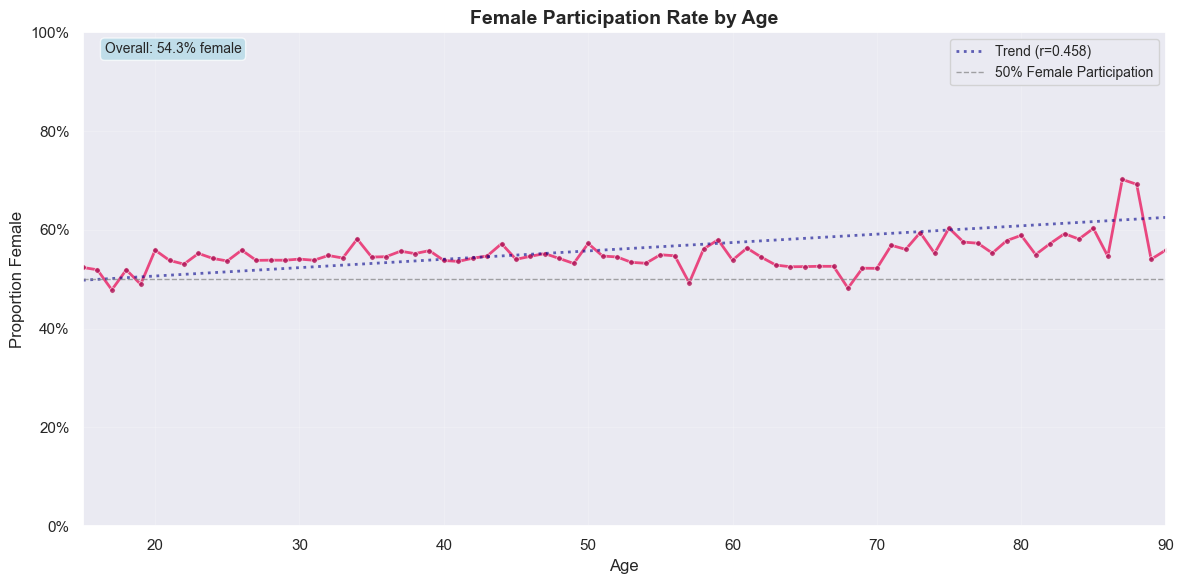

In [32]:
def create_female_rate_by_age_plot(data, figsize=(12, 6)):
    """
    Create a plot showing female participation rate by age with regression line
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing 'age' and 'female' columns
    figsize : tuple, default=(12, 6)
        Figure size for the plot
    """
    # Calculate female rate by age
    female_rate_by_age = data.groupby('age')['female'].mean()
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the line with styling
    ax.plot(female_rate_by_age.index, female_rate_by_age.values, 
            marker='o', markersize=4, linewidth=2, color='#E91E63', 
            markerfacecolor='#AD1457', markeredgecolor='white', 
            markeredgewidth=0.5, alpha=0.8)
    
    # Add regression line (dotted and transparent)
    slope, intercept, r_value, p_value, std_err = stats.linregress(female_rate_by_age.index, female_rate_by_age.values)
    regression_line = slope * female_rate_by_age.index + intercept
    ax.plot(female_rate_by_age.index, regression_line, 
            linestyle=':', linewidth=2, color='darkblue', alpha=0.6, 
            label=f'Trend (r={r_value:.3f})')
    
    # Add a horizontal reference line at 50%
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1, label='50% Female Participation')

    # Styling
    ax.set_xlabel("Age", fontsize=12)
    ax.set_ylabel("Proportion Female", fontsize=12)
    ax.set_title("Female Participation Rate by Age", fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_xlim(15, 90)  # Focus on reliable age range

    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add legend for the regression line
    ax.legend(loc='upper right', fontsize=10)
    
    # Add annotation
    ax.text(0.02, 0.98, f'Overall: {data["female"].mean():.1%} female', 
            transform=ax.transAxes, fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7),
            verticalalignment='top')
    
    plt.tight_layout()
    return fig, ax

# Create the plot
fig, ax = create_female_rate_by_age_plot(data_imputed.loc[non_imputed_indices])
plt.show()


#### Summary of the Female Participation Analysis
- **Gender Balance:** Slight female majority, consistent across most age groups.  
- **Age Trends**: Age Trends: A slight positive correlation exists between age and gender balance, reflecting the tendency for females to live longer than males.


### Preferences by Age

The `plot_weighted_preferences_by_age` function visualizes how different psychological preferences change across age groups while accounting for sampling weights to ensure population representativeness. We use this function to examine age-related trends in preferences like patience, risk-taking, and altruism, with a secondary plot showing sample sizes to assess data reliability at different ages.

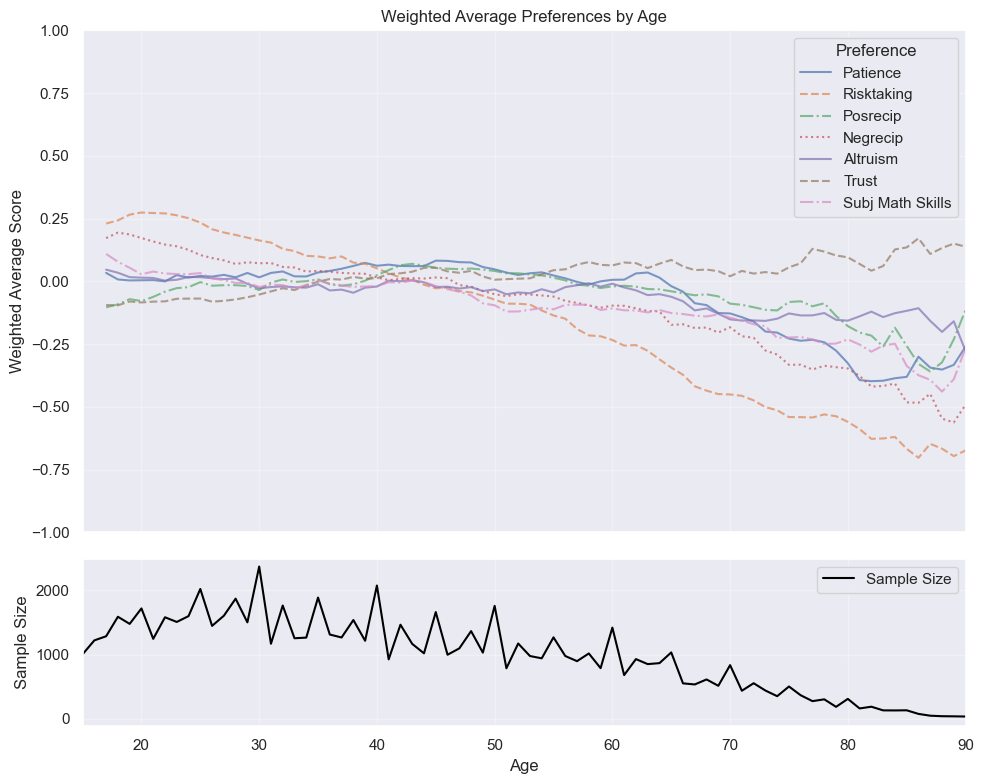

In [33]:
def plot_weighted_preferences_by_age(data, preference_columns, indices, weight_col='wgt', figsize=(10, 8)):
    """
    Create a plot showing weighted average preferences by age with sample size.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing age, preferences, and weights
    preference_columns : list
        List of preference column names to plot
    indices : pandas.Index
        Indices of rows to include in the analysis
    weight_col : str, default='wgt'
        Column name containing sample weights
    figsize : tuple, default=(10, 8)
        Figure size for the plot
    """
    # Filter data to non-imputed indices
    filtered_data = data.loc[indices].copy()
    
    # Set up the plot with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Define line styles for different preferences
    line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
    
    # Loop through each preference and plot its weighted average by age
    for col, style in zip(preference_columns, line_styles):
        # Calculate weighted average by age
        weighted_avg_by_age = (filtered_data.groupby('age')
                              .apply(lambda x: np.average(x[col], weights=x[weight_col]), include_groups=False)
                              .rolling(window=5, center=True).mean())  # Smooth with rolling average
        
        ax1.plot(weighted_avg_by_age.index, weighted_avg_by_age.values, 
                label=col.replace('_', ' ').title(), linestyle=style, alpha=0.7)

    # Plot styling for the main plot
    ax1.set_ylabel("Weighted Average Score")
    ax1.set_title("Weighted Average Preferences by Age")
    ax1.set_ylim(-1, 1)  # Focus on a narrower y-range for better detail
    ax1.legend(title="Preference", loc='upper right')
    ax1.grid(True, alpha=0.3)

    # Plot sample size by age in the secondary plot
    sample_size = filtered_data.groupby('age').size()
    ax2.plot(sample_size.index, sample_size.values, color='black', label='Sample Size')
    ax2.set_xlabel("Age")
    ax2.set_ylabel("Sample Size")
    ax2.set_xlim(15, 90)  # Limit to ages 15-90
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

plot_weighted_preferences_by_age(
    data=data_imputed,
    preference_columns=preference_columns,
    indices=non_imputed_indices,
    weight_col='wgt',
    figsize=(10, 8)
)

#### Summary of the Preferences by Age Analysis

**Stability of Preferences:** Most preferences remain relatively stable across ages 20 to 90, with only risk-taking showing a strong visible decline, suggesting that age has a limited impact on this preference, as also shown in the correlations earlier.

**Limitations of Age Analysis:** The sharp drop in sample size after age 60 indicates that data reliability decreases for older age groups, which may affect the accuracy of trends observed in later years.


### Preferences by Continent

The `plot_preference_distributions_by_continent` function creates density plots for each preference variable (and age), grouped by continent, allowing us to visually compare how the distributions of psychological traits differ across world regions. This helps identify cross-cultural patterns and regional differences in preferences within the dataset.

In [34]:
def print_quantiles_by_continent(data, indices, preference_columns):
    """
    Print quantiles (10%, 20%, 30%, 40%, 50%, 60%, 70%, 80%, 90%) for each preference by continent

    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing preference columns and continent information
    indices : pandas.Index
        Indices of rows to include in the analysis
    preference_columns : list
        List of preference column names to analyze
    """
    # Filter data to specified indices
    filtered_data = data.loc[indices].copy()
    
    # Calculate quantiles for each preference by continent
    plot_columns = preference_columns + ['age']
    
    for pref in plot_columns:
        print(f"\n{'='*60}")
        print(f"QUANTILES FOR {pref.replace('_', ' ').upper()}")
        print(f"{'='*60}")
        print(f"{'Continent':<15} {'10%':<10} {'20%':<10} {'30%':<10} {'40%':<10} {'50%':<10} {'60%':<10} {'70%':<10} {'80%':<10} {'90%':<10} {'Mean':<10} {'Std Dev':<10}")
        print(f"{'-'*60}")
        
        for continent in filtered_data['continent'].unique():
            if pd.notna(continent):
                subset = filtered_data[filtered_data['continent'] == continent][pref].dropna()
                if len(subset) > 10:  # Only calculate if we have enough data points
                    q10, q20, q30, q40, q50, q60, q70, q80, q90 = subset.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
                    mean_val = subset.mean()
                    std_val = subset.std()
                    print(f"{continent:<15} {q10:<10.3f} {q20:<10.3f} {q30:<10.3f} {q40:<10.3f} {q50:<10.3f} {q60:<10.3f} {q70:<10.3f} {q80:<10.3f} {q90:<10.3f} {mean_val:<10.3f} {std_val:<10.3f}")

# Print quantiles first
print_quantiles_by_continent(
    data=data_imputed,
    indices=non_imputed_indices,
    preference_columns=preference_columns
)



QUANTILES FOR PATIENCE
Continent       10%        20%        30%        40%        50%        60%        70%        80%        90%        Mean       Std Dev   
------------------------------------------------------------
Asia            -0.931     -0.676     -0.663     -0.442     -0.293     -0.166     -0.038     0.643      1.583      -0.051     0.960     
Europe          -1.058     -0.676     -0.548     -0.330     -0.080     0.208      0.770      1.397      1.966      0.210      1.092     
South America   -1.058     -0.803     -0.676     -0.548     -0.421     -0.293     -0.038     0.122      1.127      -0.195     0.863     
Africa          -1.058     -0.803     -0.676     -0.421     -0.293     -0.166     -0.038     0.175      1.041      -0.167     0.855     
Oceania         -0.676     -0.389     -0.043     0.249      0.680      1.046      1.512      1.838      2.147      0.720      1.055     
North America   -1.186     -0.824     -0.676     -0.548     -0.293     -0.038     0.414      

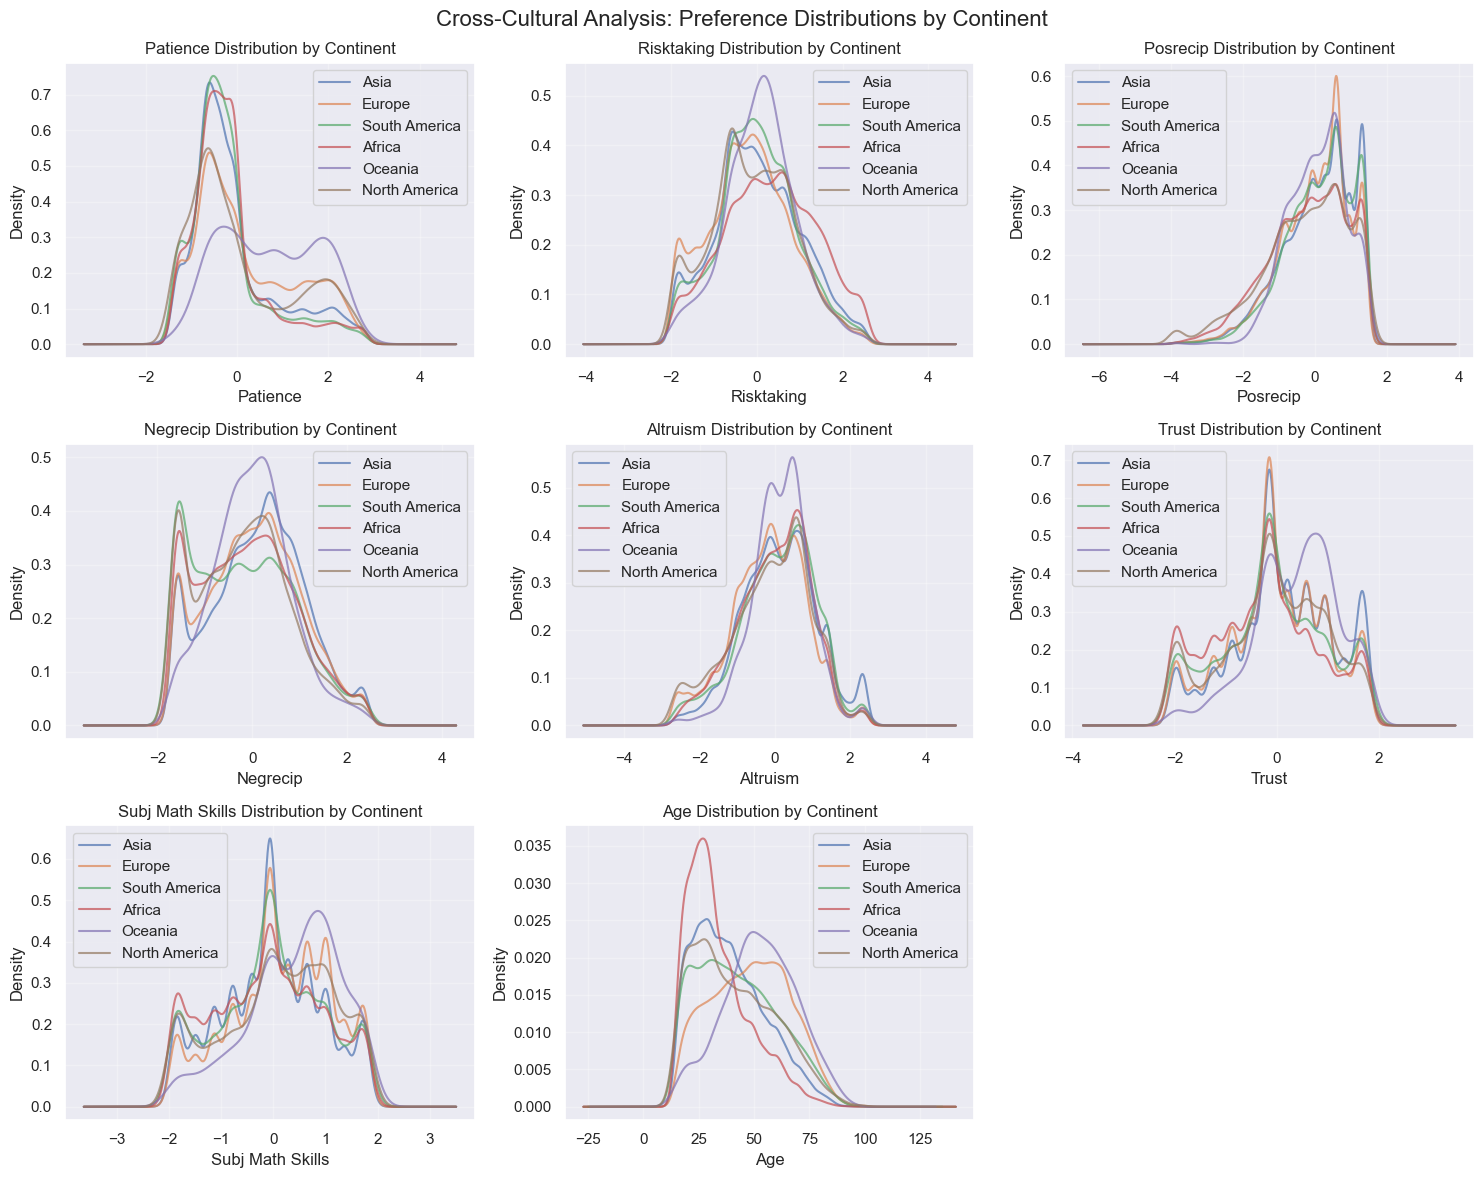

In [35]:
def plot_preference_distributions_by_continent(data, indices, preference_columns, figsize=(15, 12)):
    """
    Create density plots showing the distribution of preferences by continent.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Dataset containing preference columns and continent information
    indices : pandas.Index
        Indices of rows to include in the analysis
    preference_columns : list
        List of preference column names to plot
    figsize : tuple, default=(15, 12)
        Figure size for the plot
    """
    # Filter data to specified indices
    filtered_data = data.loc[indices].copy()
    
    # Calculate number of subplots needed (preferences + age)
    plot_columns = preference_columns + ['age']
    n_plots = len(plot_columns)
    
    # Calculate subplot grid dimensions
    rows = int(np.ceil(np.sqrt(n_plots)))
    cols = int(np.ceil(n_plots / rows))
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Plot each preference/variable
    for i, pref in enumerate(plot_columns):
        ax = axes[i]
        
        # Plot density for each continent
        for continent in filtered_data['continent'].unique():
            if pd.notna(continent):
                subset = filtered_data[filtered_data['continent'] == continent][pref].dropna()
                if len(subset) > 10: 
                    subset.plot.density(ax=ax, label=continent, alpha=0.7)
        
        ax.set_title(f'{pref.replace("_", " ").title()} Distribution by Continent')
        ax.set_xlabel(pref.replace("_", " ").title())
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Remove extra subplots if any
    for i in range(n_plots, len(axes)):
        axes[i].remove()
    
    plt.suptitle("Cross-Cultural Analysis: Preference Distributions by Continent", 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()


plot_preference_distributions_by_continent(
    data=data_imputed,
    indices=non_imputed_indices,
    preference_columns=preference_columns,
    figsize=(15, 12)
)

The following key insights can be drawn from the preference distributions by continent:

* **Patience:** People in Oceania show distinctly high patience, with most reporting well above the global midpoint. Europe also leans toward above-average patience, though less extremely. North America and Asia sit close to the middle, with roughly equal numbers above and below average. Africa and South America report lower patience overall, with many more people below the midpoint than above it.

* **Risk-taking:** Both Africa and South America lean toward higher risk-taking compared to other regions. Africa shows the strongest values for risk, but South America also tilts above neutral more often than not. In contrast, Europe is the most risk-averse, favoring safety. Asia, North America, and Oceania cluster around moderate risk preferences, neither strongly adventurous nor strongly cautious.

* **Positive reciprocity:** South America, Asia, Europe, and Oceania each show a solid tendency to reward kindness, with most people above the neutral mark. Africa and North America are less inclined to return favors, with many falling below the midpoint.

* **Negative reciprocity:** Asia and Europe are moderately willing to punish unfairness. Oceania is essentially neutral—about as many people want to punish as to forgive. Africa, South America, and North America generally shy away from punishing, with most falling below the neutral point.

* **Altruism:** Oceania is the most altruistic region. Asia and South America also lean strongly toward helping behavior. Africa and North America sit near the midpoint, showing mixed willingness to give. Europe tends to be the least altruistic, with more people reluctant to sacrifice for others.

* **Trust:** Oceania has the highest trust in others, with a clear majority above neutral. Asia shows moderate trust, with slightly more people trusting than distrusting. Europe, South America, and North America hover near neutral, with roughly equal numbers trusting and distrusting. Africa reports the lowest trust, with most people skeptical of others’ intentions.

* **Subjective math skills:** Oceania feels most confident in its math abilities, followed by Europe and North America, which also rate themselves above average. Asia and South America place themselves near the global midpoint, while Africa reports the lowest math confidence, with many feeling less skilled.

* **Age Distribution:** Africa’s sample is the youngest, with most respondents in their twenties and early thirties. Asia also skews young but includes more middle-aged adults than Africa. South America and North America show a broader mix of ages, centering on people in their late thirties and early forties. Europe’s participants tend to be older still, with many in their late forties and fifties. Oceania has the oldest profile overall, featuring a large share of respondents in their fifties and early sixties.

In [36]:
avg_pref_by_country

isocode  patience  risktaking  posrecip  negrecip  altruism     trust  \
0      AFG -0.196886    0.129260  0.297961  0.267240  0.187868  0.324915   
1      ARE -0.089432    0.085381  0.079125  0.217701  0.161038  0.511629   
2      ARG -0.218146    0.048398  0.148939 -0.128608  0.038985 -0.207111   
3      AUS  0.673235    0.156806  0.074660  0.026238  0.152493  0.299767   
4      AUT  0.632319   -0.050186  0.166648 -0.048520 -0.046974  0.139993   
..     ...       ...         ...       ...       ...       ...       ...   
70     USA  0.815424    0.141157  0.212469  0.017242  0.402663  0.149405   
71     VEN -0.233023    0.248768  0.043857 -0.198912  0.081218  0.104691   
72     VNM  0.134030    0.036028 -0.338847 -0.072235 -0.200364  0.135680   
73     ZAF  0.056292    0.973838 -0.836766  0.031259 -0.320075 -0.168190   
74     ZWE -0.235991    0.531099 -0.162693 -0.124975 -0.035209 -0.507565   

    subj_math_skills  
0          -0.379637  
1           0.347069  
2          -0.144578  
3           0.361738  
4           0.376745  
..               ...  
70          0.533041  
71          0.216847  
72         -0.083811  
73          0.051893  
74         -0.274028  

[75 rows x 8 columns]

The map displays average preference values for each country in 2012 on an interactive world view. 

In [37]:
def create_map(stats, metrics, output_base):
    m = folium.Map(location=[20, 0], zoom_start=2.5, tiles=None)
    folium.TileLayer('CartoDB positron', control=False, show=True).add_to(m)

    title = (
        "<div style='position:absolute;top:10px;left:10px;"
        "background:white;padding:10px 15px;border:1px solid gray;"
        "border-radius:8px;box-shadow:2px 2px 5px rgba(0,0,0,0.2);"
        "font-size:16px;z-index:9999;'>"
        "<b>Average Preferences per Country (2012)</b><br>"
        "Select a metric in the toolbox on the right<br>"
        "<i>Grey areas = no data.</i></div>"
)

    m.get_root().html.add_child(folium.Element(title))

    cmap = cm.linear.RdBu_11.scale(-1, 1).to_step(n=11)
    cmap.caption = 'Average Preference Score'
    m.add_child(cmap)

    labels = {
        'patience': 'Patience',
        'risktaking': 'Risk Taking',
        'posrecip': 'Positive Reciprocity',
        'trust': 'Trust',
        'altruism': 'Altruism',
        'negrecip': 'Negative Reciprocity',
        'subj_math_skills': 'Subjective Math Skills'
    }

    geojson = 'https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json'

    for metric in metrics:
        fg = folium.FeatureGroup(name=labels[metric], overlay=False, show=(metric == 'trust'))

        def style_fn(feature, metric=metric):
            iso = feature.get('id')
            row = stats[stats['isocode'] == iso]
            if row.empty:
                return {'fillColor': 'lightgray', 'color': 'black', 'weight': 0.5, 'fillOpacity': 0.8}
            z = row[metric].iloc[0]
            return {'fillColor': cmap(z), 'color': 'black', 'weight': 0.5, 'fillOpacity': 0.8}

        tooltip = GeoJsonTooltip(fields=['name', metric],
                                 aliases=['Country:', labels[metric] + ':'],
                                 localize=True, labels=True)

        gj = GeoJson(geojson, style_function=style_fn, tooltip=tooltip, control=False)

        for feat in gj.data['features']:
            iso = feat.get('id')
            val = stats.loc[stats['isocode'] == iso, metric]
            feat['properties'][metric] = f"{val.values[0]:.2f}" if not val.empty else 'n/a'
        
        gj.add_to(fg)
        fg.add_to(m)
    LayerControl(collapsed=False).add_to(m)


    return m

In [38]:
m = create_map(avg_pref_by_country, preference_columns, output_base='map.html')

m

**Key Insights:**
- **Patience**: Low patience Scores in South and Central America, higher patience scores in northern Europe, Australia and North America.
- **Risktaking**: High in South Africa, moderate in the US and low in Russia.
- **Positive Reciprocity**: Strong in Brasil, and generally South America, moderate in North America, low in Africa and Mexico.
- **Negative Reciprocity**: High in Saudi Arabia, low in Morocco.
- **Altruism**: Low in Mexico, moderate in Europe, high in Brasil and China.
- **Trust**: High in China, Australia, Canada, and Northern Europe, low in Mexico and South Africa.
- **Subjective Math Skills**: High in Northern & Central Europe, North America, Australia, and low in most of Africa and Cambodia.

#### Summary: Main findings of EDA

1. Are country-level preference profiles related to differences in geography, language?
* Yes, this can be seen in the correlation analysis in Problem 1, but also in the density plots in Problem 2, where we see that preferences vary by continent and region and language. For example, patience is highest in Oceania and Northern Europe, while risktaking is highest in Africa and South America. We also illustrated this in the maps.
2. How large is cross-country variation in preferences relative to within-country variation?
* The cross-country variation in preferences is substantial, with country-level factors explaining a significant portion of the variance in preferences. For example, patience has a large effect size (η = .384), indicating that country explains about 14.7% of the variance in this preference. This suggests that while individual differences exist, country context plays a crucial role in shaping preferences.
3. Age plays a role in preferences, with older individuals being less likely to take risks and less likely to exhibit negative reciprocity. However, preferences remain relatively stable across ages 20 to 80, suggesting that individual differences or other factors might play a larger role than age in shaping these characteristics.
4. Gender also influences preferences, with females rating themselves lower in risk-taking and their subjective math skills. However, the differences are generally small in magnitude.


## Supervised Machine Learning

The analysis then turns to a more systematic, regression-based analysis of potential determinants of preference variation. The results establish that at the individual level, preferences vary systematically with gender, cognitive ability, and age. For example, women are more impatient, less risk-tolerant, and more prosocial than men. Cognitive skills are uniformly positively linked to patience, risk taking, and social preferences, and all preferences are subject to age patterns. At the same time, the relationships between sociodemographics and preferences hide considerable heterogeneity across countries: while some relationships, such as between risk aversion and gender, go in the same direction in almost all countries, others, such as the age profile for patience, appear to depend on the level of development.

#### a)
Try to predict the subjects' countries of origin using the information provided. <br>
Report the performance measures for different predictor variables.

We use tree based model to predict the country of origin because the relationship between country and preferences is likely to be non-linear and complex, making tree-based models suitable for capturing these relationships. <br>

* Target Variable: Country
* Type: Multiclass classification (multiple countries)

We are encoding the categorical variables 'language' and 'country' into numerical formats (label and one-hot encoding) to prepare the dataset for machine learning classification of country of origin based on preferences, demographics, and language.

In [39]:
# Label encode 'language'
le_language = LabelEncoder()
data_encoded = data_imputed.copy()
data_encoded['language_encoded'] = le_language.fit_transform(data_encoded['language'])

# Encode target variable 'country'
le_country = LabelEncoder()
data_encoded['country_encoded'] = le_country.fit_transform(data_encoded['country'])

# Define features and target
feature_cols = preference_columns + ['female', 'age', 'language_encoded']

# One-hot encode language
onehots = pd.get_dummies(data_encoded, columns=['language'], prefix="language_onehot", drop_first=False)

# insert new columns in data_encoded
data_encoded = pd.concat([data_encoded, onehots.filter(like='language_onehot_')], axis=1)

features_onehot = preference_columns + ['female', 'age'] + [col for col in data_encoded.columns if col.startswith("language_onehot_")]

# Train/test split of indices 
train, test = train_test_split(data_encoded.index, test_size=0.2, random_state=42)

For classification, we will use both a Random Forest Classifier and a Gradient Boosting Classifier, as these are powerful tree-based models that can handle complex non-linear relationships and interactions in the data.

In [40]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(random_state=42, eval_metric='logloss', tree_method='hist')

The `fit_model` function trains a machine learning model on the training data using specified features, target, and sample weights.

In [41]:
def fit_model(model, data_imputed, feature_cols, target_col, train):
    """
    Fits the model on the training data.
    """
    model.fit(data_imputed.loc[train, feature_cols], data_imputed.loc[train, target_col], sample_weight=data_imputed.loc[train, 'wgt'])
   
    print(f"Model {model.__class__.__name__} has been fitted on the training data.")
    return model

The `evaluate_model` function assesses a trained model's performance on a test set by computing accuracy, macro-averaged F1 score, and feature importances, then prints a summary report.

In [42]:
def evaluate_model(model, data_imputed, feature_cols, target_col, test):
    """
    Evaluates the fitted model on the test set and prints an evaluation report.
    """

    accuracy = model.score(data_imputed.loc[test, feature_cols], data_imputed.loc[test, target_col])
    f1 = f1_score(data_imputed.loc[test, target_col], model.predict(data_imputed.loc[test, feature_cols]), average='macro')

    # Feature importances
    importances = model.feature_importances_ if hasattr(model, 'feature_importances_') else {col: -1 for col in feature_cols}
    feature_importances = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

    # Create the evaluation report
    report = {
        'accuracy': accuracy,
        'f1_score': f1,
        'feature_importances': feature_importances
    }

    print("-" * 50)
    print(f"Evaluation Report of {model.__class__.__name__}")
    print("-" * 50)
    print(f"Accuracy: {report['accuracy']:.4f}")
    print(f"F1 Score: {report['f1_score']:.4f}")
    print("Feature Importances:")
    for feature, importance in report['feature_importances'].items():
        print(f"  {feature}: {importance:.4f}")
    print("-" * 50)
    return report

In [43]:
language_columns = ['language_encoded']

#### Predict Countries with Language Features only

In [44]:
# Fit the random forest model on language columns only
rf_language = fit_model(rf, data_encoded, language_columns,'country_encoded', train)
# Evaluate the model on the test set
rf_language_report = evaluate_model(rf_language, data_encoded, language_columns, 'country_encoded', test)

Model RandomForestClassifier has been fitted on the training data.
--------------------------------------------------
Evaluation Report of RandomForestClassifier
--------------------------------------------------
Accuracy: 0.6238
F1 Score: 0.5604
Feature Importances:
  language_encoded: 1.0000
--------------------------------------------------


In [45]:
xgbm_language = fit_model(xgb, data_encoded, language_columns, 'country_encoded', train)
xgbm_language_report = evaluate_model(xgbm_language, data_encoded, language_columns, 'country_encoded', test)

Model XGBClassifier has been fitted on the training data.
--------------------------------------------------
Evaluation Report of XGBClassifier
--------------------------------------------------
Accuracy: 0.6212
F1 Score: 0.5598
Feature Importances:
  language_encoded: 1.0000
--------------------------------------------------


XGBoost is slightly better than Random Forest, but both perform similarly (Accuracy ≈ 0.62).

#### Predict Countries with Preferences only

In [46]:
rf_pref = fit_model(rf, data_encoded, preference_columns, 'country_encoded', train)
rf_pref_report = evaluate_model(rf_pref, data_encoded, preference_columns, 'country_encoded', test)

Model RandomForestClassifier has been fitted on the training data.
--------------------------------------------------
Evaluation Report of RandomForestClassifier
--------------------------------------------------
Accuracy: 0.1471
F1 Score: 0.1336
Feature Importances:
  altruism: 0.1776
  negrecip: 0.1715
  risktaking: 0.1700
  patience: 0.1452
  posrecip: 0.1331
  subj_math_skills: 0.1095
  trust: 0.0931
--------------------------------------------------


In [47]:
xgbm_pref = fit_model(xgb, data_encoded, preference_columns, 'country_encoded', train)
xgbm_pref_report = evaluate_model(xgbm_pref, data_encoded, preference_columns, 'country_encoded', test)

Model XGBClassifier has been fitted on the training data.
--------------------------------------------------
Evaluation Report of XGBClassifier
--------------------------------------------------
Accuracy: 0.1977
F1 Score: 0.1857
Feature Importances:
  altruism: 0.1781
  patience: 0.1522
  trust: 0.1405
  posrecip: 0.1378
  negrecip: 0.1324
  risktaking: 0.1322
  subj_math_skills: 0.1270
--------------------------------------------------


1. **Prediction Result** 
    When we predict countries using only the preference variables, both Random Forest (Accuracy ≈ 0.15) and XGBoost (Accuracy ≈ 0.20) perform poorly, suggesting that preferences alone are not sufficient to predict a person's country of origin. This raises the question of whether the preferences contribute meaningful information to the model or simply act as noise. To investigate this, we now include both language features and preferences as inputs to see whether prediction performance improves compared to using language features alone.

2. **Feature Importance**: 
    * When looking at feature importance scores, we find that for both models altruism was the most important feature, meaning that altruism is the most predictive preference feature for predicting a person's country of origin. 
    * For the RF model, the second most important feature was negrecip, while for the XGBoost model, the second most important feature was patience.

#### Predict Countries with all features (preferences + language)

In [48]:
# Now fit the model on all features (language + preferences)
rf_all = fit_model(rf, data_encoded, feature_cols, 'country_encoded', train)
rf_all_report = evaluate_model(rf_all, data_encoded, feature_cols, 'country_encoded', test)

Model RandomForestClassifier has been fitted on the training data.
--------------------------------------------------
Evaluation Report of RandomForestClassifier
--------------------------------------------------
Accuracy: 0.6859
F1 Score: 0.6681
Feature Importances:
  language_encoded: 0.3535
  altruism: 0.0959
  negrecip: 0.0886
  risktaking: 0.0885
  age: 0.0835
  patience: 0.0802
  posrecip: 0.0739
  subj_math_skills: 0.0598
  trust: 0.0578
  female: 0.0184
--------------------------------------------------


In [49]:
xgb_all = fit_model(xgb, data_encoded, feature_cols, 'country_encoded', train)
xgb_all_report = evaluate_model(xgb_all, data_encoded, feature_cols, 'country_encoded', test)

Model XGBClassifier has been fitted on the training data.
--------------------------------------------------
Evaluation Report of XGBClassifier
--------------------------------------------------
Accuracy: 0.7490
F1 Score: 0.7369
Feature Importances:
  language_encoded: 0.8005
  negrecip: 0.0616
  age: 0.0592
  patience: 0.0178
  subj_math_skills: 0.0163
  risktaking: 0.0159
  altruism: 0.0128
  posrecip: 0.0068
  trust: 0.0062
  female: 0.0029
--------------------------------------------------


1. **Accuracy**: When we predict the countries using both language features and preferences, we achieve a significantly higher accuracy with both Random Forest (Accuracy ≈ 0.69) and XGBoost (Accuracy ≈ 0.75). This indicates that adding the preference features improves the model's ability to predict the country of origin, confirming that preferences do provide valuable information beyond what language features alone can offer.

2. **Feature Importance**: 
    * While being the most important features in both models, language has a higher feature importance in XGBoost than in the RF model, which shows that XGBoost can better handle the language features.


#### Prediction of Countries: Analysis of Feature Importance

We now want to analyze the feature importance of the different features used in the model. <br>
For shap values we first have to one hot encode the language features.

In [50]:
# Retrain Xgboost on the One-Hot encoded features for the shap analysis 
xgb_onehot = fit_model(xgb, data_encoded, features_onehot, 'country_encoded', train)
xgb_onehot_report = evaluate_model(xgb_onehot, data_encoded, features_onehot, 'country_encoded', test)

Model XGBClassifier has been fitted on the training data.
--------------------------------------------------
Evaluation Report of XGBClassifier
--------------------------------------------------
Accuracy: 0.7471
F1 Score: 0.7353
Feature Importances:
  language_onehot_Chinese: 0.0487
  language_onehot_Farsi: 0.0479
  language_onehot_Bosnian: 0.0453
  language_onehot_Chichewa: 0.0354
  language_onehot_Twi: 0.0334
  language_onehot_Hindi: 0.0332
  language_onehot_Moroccan Arabic: 0.0295
  language_onehot_Kinyarwanda: 0.0290
  language_onehot_Swedish: 0.0254
  language_onehot_Czech: 0.0248
  language_onehot_Khmer: 0.0231
  language_onehot_Japanese: 0.0225
  language_onehot_Korean: 0.0225
  language_onehot_Lithuanian: 0.0224
  language_onehot_Greek: 0.0223
  language_onehot_Indonesian: 0.0222
  language_onehot_Turkish: 0.0221
  language_onehot_Hungarian: 0.0220
  language_onehot_Finnish: 0.0219
  language_onehot_Vietnamese: 0.0212
  language_onehot_Hebrew: 0.0211
  language_onehot_Thai: 0.0

#### Analysis of Feature Importance
To better understand the contribution of each feature to the model's predictions, we use SHAP (SHapley Additive exPlanations) values. SHAP values provide a unified measure of feature importance by quantifying how much each feature contributes to the model's output for each individual prediction.

In [51]:
# feature_cols_without language
# Create a SHAP explainer for the XGBoost model (all features)
explainer = shap.TreeExplainer(xgb_onehot, approximate=True)

In [52]:
explanation = explainer(data_encoded.loc[test, features_onehot])
shap_values = explanation.values

We now analyze the significance of various preferences and language features in predicting the country of origin for the five most common countries in the dataset: China, India, Iran, Russia, and the United States.

In [53]:
# Create inverse mapping dictionary from encoded values to country names
country_mapping = {}
unique_encoded = data_encoded['country_encoded'].unique()
for encoded_val in unique_encoded:
    country_name = le_country.inverse_transform([encoded_val])[0]
    country_mapping[country_name] = encoded_val

# Count data points per country and sort by frequency
country_counts = data_encoded['country'].value_counts()
print("Top 5 most common countries by number of data points:")
print("=" * 50)
for i, (country, count) in enumerate(country_counts.head(5).items(), 1):
    encoded_val = country_mapping[country]
    print(f"{i}. {country}: {count} data points (encoded as {encoded_val})")

print(f"\nTotal countries in dataset: {len(country_mapping)}")
print(f"Country mapping dictionary created with {len(country_mapping)} entries")

Top 5 most common countries by number of data points:
1. China: 2574 data points (encoded as 14)
2. India: 2539 data points (encoded as 30)
3. Iran: 2507 data points (encoded as 32)
4. Russia: 1498 data points (encoded as 54)
5. United States: 1072 data points (encoded as 72)

Total countries in dataset: 76
Country mapping dictionary created with 76 entries


We are creating some helper functions to calculate the SHAP values and visualize them.

In [54]:
feat_no_lang = preference_columns + ['female', 'age']
feat_lang = [col for col in features_onehot if col not in feat_no_lang]

def get_idx(data, cols):
    return [data.columns.get_loc(c) for c in cols]

#### China

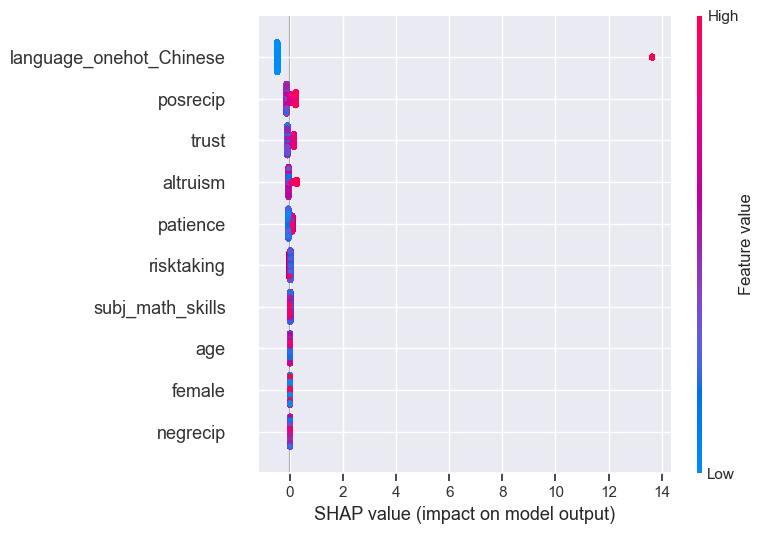

In [55]:
feat_china = feat_no_lang + ['language_onehot_Chinese']
feat_china_idx = get_idx(data_encoded[features_onehot], feat_china)

shap_values_china = (shap_values[:, feat_china_idx, 14])

shap.summary_plot(shap_values_china, data_encoded.loc[test, feat_china], 
                  title="SHAP Summary Plot for XGBoost Model (China)", max_display=10)

* Here we see the most important features for predicting China
* The most important feature for predicting China is the language feature Chinese, which is not surprising, as the majority of respondents from China speak Chinese.
* The second most important feature for the model is the preference posrecip, which indicates that the model interprets that individuals from China tend to have higher levels of positive reciprocity compared to individuals from other countries.

#### India

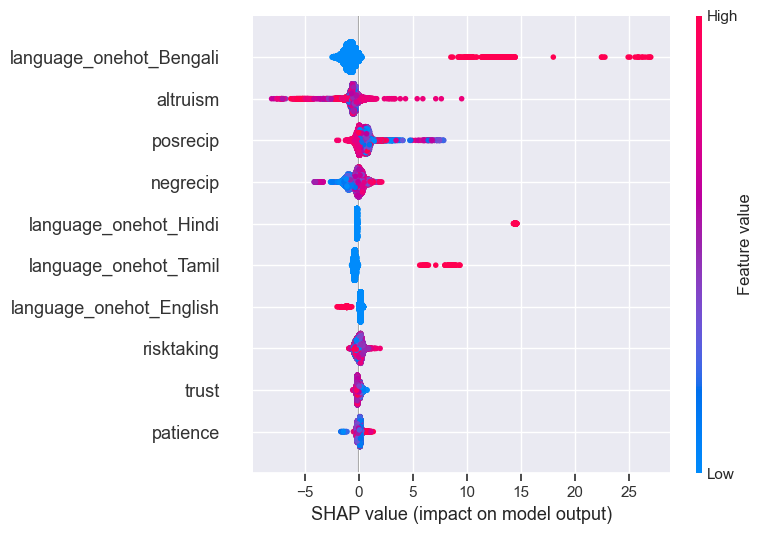

In [56]:
feat_india = feat_no_lang + ['language_onehot_Bengali', 'language_onehot_Tamil', 'language_onehot_Hindi', 'language_onehot_English']
feat_india_idx = get_idx(data_encoded[features_onehot], feat_india)
shap_values_india = (shap_values[:, feat_india_idx, 30])
shap.summary_plot(shap_values_india, data_encoded.loc[test, feat_india],
                  title="SHAP Summary Plot for XGBoost Model (India)", max_display=10)

* Here we look at the feature importance for predicting India. In India, a lot of different languages are spoken, which is probably the reason why the language feature is not as important as in e.g China.
* The most important feature for predicting India is altruism, which indicates that individuals from India tend to have higher levels of altruism compared to individuals from other countries.
* The second most important feature is posrecip
* The third most important feature is the language feature Hindi, which indicates that individuals from India tend to speak Hindi more often than individuals from other countries.
* Here we see that preferences have a additional explanatory power for predicting the country of origin, as the preferences are more important than the language features in a country like India, that speaks multiple languages.

#### Iran

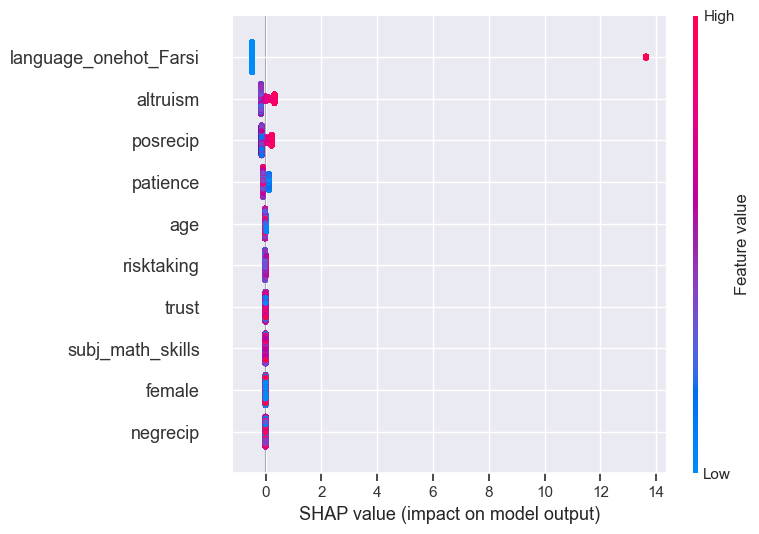

In [57]:
feat_iran = feat_no_lang + ['language_onehot_Farsi']
feat_iran_idx = get_idx(data_encoded[features_onehot], feat_iran)

shap_values_iran = (shap_values[:, feat_iran_idx, 32])
shap.summary_plot(shap_values_iran, data_encoded.loc[test, feat_iran],
                  title="SHAP Summary Plot for XGBoost Model (Iran)", max_display=10)

* Irans feature importance shows that the language feature is the most important feature for predicting Iran, which is not surprising, as the majority of respondents from Iran speak Farsi. The farsi feature value is low indicating that if someone does not speak Farsi, the model predicts that the person is not from Iran.

#### Russia

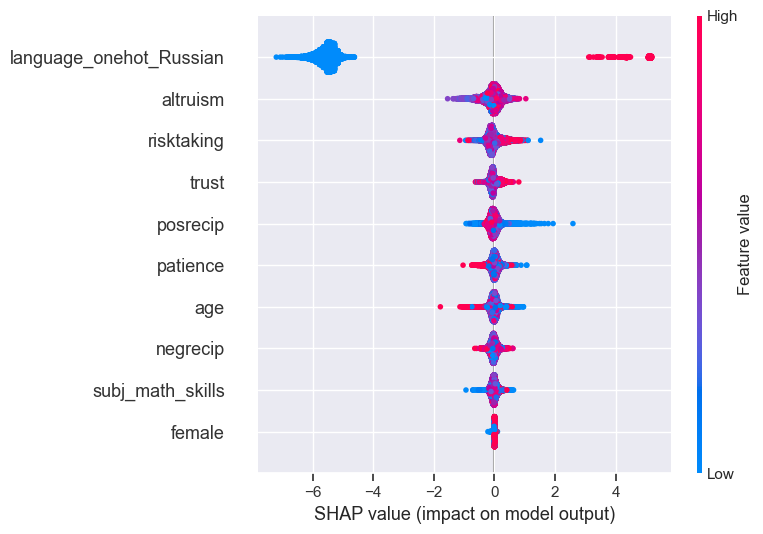

In [58]:
feat_russia = feat_no_lang + ['language_onehot_Russian']
feat_russia_idx = get_idx(data_encoded[features_onehot], feat_russia)

shap_values_russia = (shap_values[:, feat_russia_idx, 54])
shap.summary_plot(shap_values_russia, data_encoded.loc[test, feat_russia],
                  title="SHAP Summary Plot for XGBoost Model (Russia)", max_display=10)




* The feature importance for predicting Russia shows that the language feature Russian is the most important feature for predicting Russia, which is not surprising, as the majority of respondents from Russia speak Russian. The feature value is low indicating that if someone does not speak Russian, the model predicts that the person is not from Russia.

#### United States

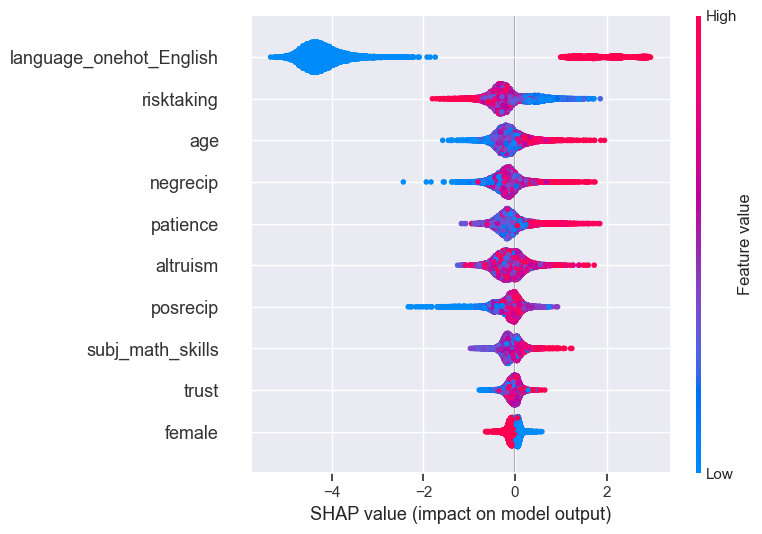

In [59]:
feat_usa = feat_no_lang + ['language_onehot_English']
feat_usa_idx = get_idx(data_encoded[features_onehot], feat_usa)

shap_values_usa = (shap_values[:, feat_usa_idx, 72])
shap.summary_plot(shap_values_usa, data_encoded.loc[test, feat_usa],
                  title="SHAP Summary Plot for XGBoost Model (USA)", max_display=10)

* When predicting if someone is from the USA, besides English, important features are age, patience, risktaking and altruism. This shows that the model not only uses the language feature to predict the country of origin, but also the preferences.

The feature importance analysis reveals that while language features are the most important predictors for countries with a dominant language (like China and Iran), preferences also play a significant role in countries with diverse languages (like India and the USA). This suggests that preferences can provide additional context and nuance to country predictions, especially in multilingual contexts.

#### Prediction of Continents
We want to predict the continents of the respondents based on their preferences. This will allow us to see if we can achieve similar or better performance compared to predicting countries. That would show us if the differences of preferences are more pronounced on a continental level than on a country level. <br>

In [60]:
data_encoded_continent = data_imputed.copy()

# Encode target variable 'continent'
le_continent = LabelEncoder()
data_encoded_continent['continent_encoded'] = le_continent.fit_transform(data_encoded_continent['continent'])

# Define features and target
feature_cols = preference_columns + ['female', 'age']

# Train/test split of indices 
train_continent, test_continent = train_test_split(data_encoded_continent.index, test_size=0.2, random_state=42)

In [61]:
xgbm_continent = fit_model(xgb, data_encoded_continent, feature_cols, 'continent_encoded', train_continent)
xgbm_continent_report = evaluate_model(xgbm_continent, data_encoded_continent, feature_cols, 'continent_encoded', test_continent)

Model XGBClassifier has been fitted on the training data.
--------------------------------------------------
Evaluation Report of XGBClassifier
--------------------------------------------------
Accuracy: 0.5012
F1 Score: 0.3142
Feature Importances:
  age: 0.1283
  altruism: 0.1279
  patience: 0.1228
  subj_math_skills: 0.1185
  posrecip: 0.1090
  risktaking: 0.1081
  trust: 0.1017
  negrecip: 0.0985
  female: 0.0853
--------------------------------------------------


* We see that predicting the continents based on preferences, age & gender is way more accurate than predicting the countries. <br>
* This suggests that the differences in preferences / age / gender are more pronounced on a continental level than on a country level
* The feature importance analysis when predicting the continents shows that the most important features were the age, while followed by the preferences altruism, patience and subj math skills. This suggests that for the models prediction, besides age the continents differ most in the preferences altruism, patience and subj math skills.

#### b)
Try to fill the gaps in the preference measures in the data using appropriate prediction models.

Because we had the best results with the XGBoost model, we will use this model to predict the missing values in the preference measures. <br>

In [62]:
xgb_regression = XGBRegressor(random_state=42)

In [63]:
def get_feat_cols_regression(feature_cols, target_col):
    """
    Returns the feature columns for regression by excluding the target column.
    """
    return [col for col in feature_cols if col != target_col] + ['country_encoded']

In [64]:
results = {}

# For each preference, fit a regression model to predict its missing values
for pref in preference_columns:
    
    has_values = data_encoded.index[data_encoded[pref + '_imputed'] == False].tolist()
    missing_values = data_encoded.index[data_encoded[pref + '_imputed'] == True].tolist()

    # Print the column name and the number of missing values
    print(f"Processing preference '{pref}': {len(missing_values)} missing values out of {len(data_encoded)} total rows.")

    if len(missing_values) > 0:
        feature_pref_cols = get_feat_cols_regression(feature_cols, pref)
        fit_model(xgb_regression, data_encoded, feature_pref_cols, pref, has_values)

        # Evaluate r2 score in sample
        r2_score = xgb_regression.score(data_encoded.loc[has_values, feature_pref_cols], data_encoded.loc[has_values, pref])
        print(f"R^2 score for {pref}: {r2_score:.4f}")


        # Fill missing values by predicting with the trained model
        data_encoded.loc[missing_values, pref] = xgb_regression.predict(data_encoded.loc[missing_values, feature_pref_cols])


Processing preference 'patience': 607 missing values out of 80337 total rows.
Model XGBRegressor has been fitted on the training data.
R^2 score for patience: 0.3313
Processing preference 'risktaking': 634 missing values out of 80337 total rows.
Model XGBRegressor has been fitted on the training data.
R^2 score for risktaking: 0.3709
Processing preference 'posrecip': 148 missing values out of 80337 total rows.
Model XGBRegressor has been fitted on the training data.
R^2 score for posrecip: 0.4015
Processing preference 'negrecip': 1801 missing values out of 80337 total rows.
Model XGBRegressor has been fitted on the training data.
R^2 score for negrecip: 0.3300
Processing preference 'altruism': 434 missing values out of 80337 total rows.
Model XGBRegressor has been fitted on the training data.
R^2 score for altruism: 0.3958
Processing preference 'trust': 1563 missing values out of 80337 total rows.
Model XGBRegressor has been fitted on the training data.
R^2 score for trust: 0.3065
Proc

* Across all seven preferences, the XGBRegressor achieves R² scores in the 0.30–0.40 range, meaning it explains roughly 30–40 % of the variability in each preference compared to a mean‑imputation baseline (which by definition has R² = 0).

* The R² values only vary modestly—from 0.298 (subjective math skills) up to 0.402 (positive reciprocity)—indicating that no single preference is drastically easier or harder to predict from the rest.

* Although each preference is partly correlated with the others, the model’s non‑zero R² demonstrates that each target variable contains unique structure not captured by simple global means.

* Superior to simple imputer: By leveraging gradient‑boosted trees rather than imputing the overall mean, we capture nuanced interactions among demographics (“country_encoded”) and other preferences, getting consistently better estimates for missing entries.

* Even for preferences with very different counts of missing values (e.g. 607 for patience vs. 1,801 for negative reciprocity), R² remains in a narrow band—showing robustness of the XGB imputer against varying data sparsity.

* With ~30–40 % of within‑sample variance recovered, our imputed dataset will retain substantially more informative signal than mean‑imputation; However, it still leaves room for improvement, as 60–70 % of variance remains unexplained.

## Unsupervised Machine Learning

#### PCA Analysis of Preferences
Now we’re applying PCA because:

* We want to see which preference measures explain the most variance, revealing the dominant dimensions that drive individual differences.

* We want to understand how strongly each feature “spreads out”, so we know which preferences vary together (or in opposition).

In [65]:
pca = PCA(n_components=7)
pca.fit(data_imputed.loc[non_imputed_indices, preference_columns])
print("Share of variance explained by each component:", pca.
explained_variance_ratio_*100)
print("Share of variance explained by all components:", sum(pca.
explained_variance_ratio_*100))

Share of variance explained by each component: [24.98294013 18.06945884 13.60091634 12.43850754 11.64590174 10.51596451
  8.7463109 ]
Share of variance explained by all components: 100.00000000000001


* The first component captures about 25% of the total variance in our data, which is the largest single chunk of information, but no single component dominates completely. This suggests that our data has multiple meaningful dimensions rather than one overwhelming factor.
* The variance is distributed relatively evenly across the first several components (ranging from 25% down to about 9%), indicating that our preference structure is multidimensional and we'll likely need multiple components to capture the essential patterns in the data.


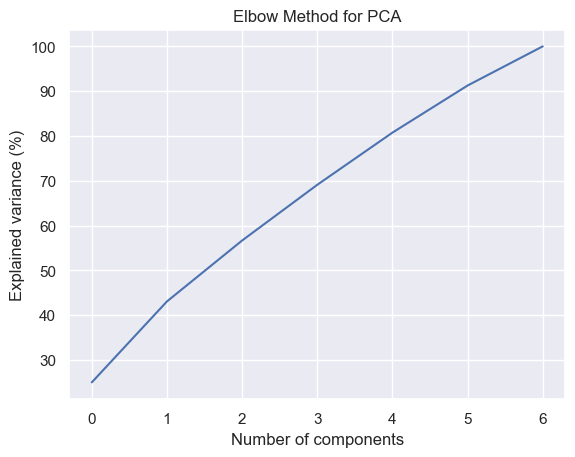

In [66]:
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")
plt.title("Elbow Method for PCA")
plt.show()

* There's no sharp "elbow" or dramatic drop-off point in the cumulative variance curve - instead, it shows a smooth, gradual increase, which makes it harder to identify a clear optimal number of components using this method alone.
* By the 4th component, we're capturing about 80% of the variance, and we need all 6-7 components to reach 90-100%, suggesting that if we want a more parsimonious model, we might consider keeping 3-4 components as a reasonable trade-off between dimensionality reduction and information retention.

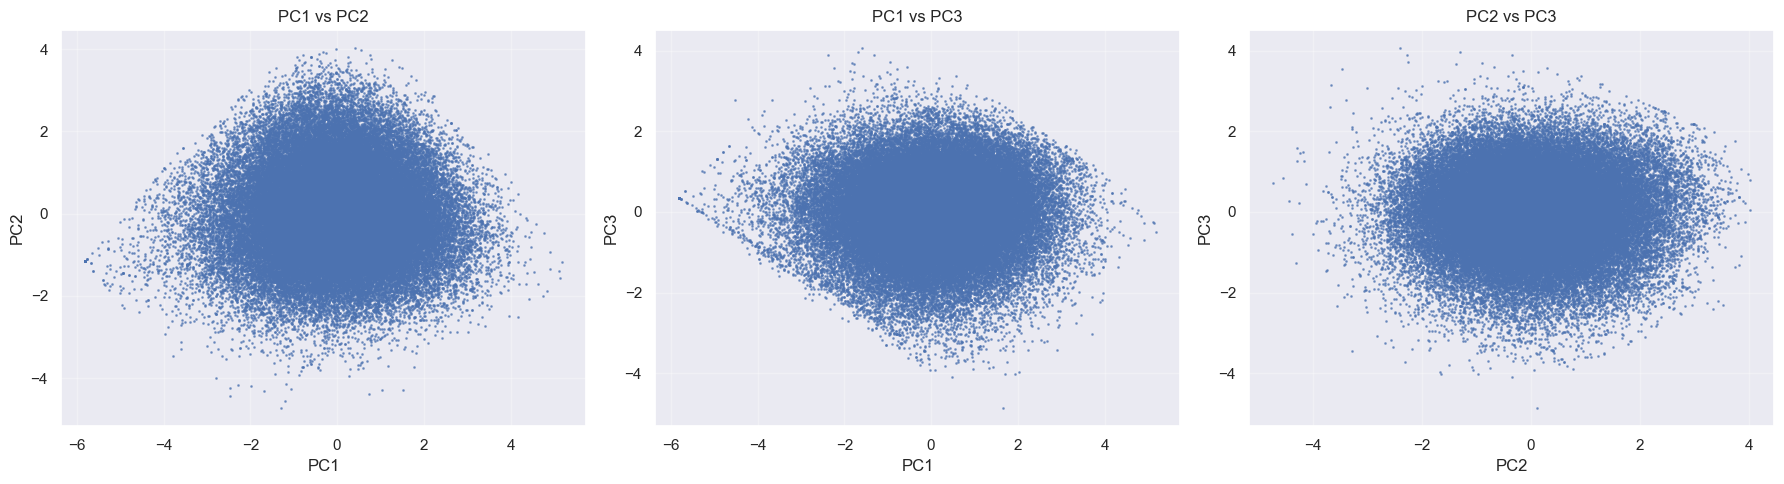

PCA Component Loadings:
                    PC1    PC2    PC3    PC4    PC5    PC6    PC7
patience          0.348 -0.317 -0.368  0.694 -0.324 -0.232  0.046
risktaking        0.361 -0.456 -0.259 -0.207  0.155  0.716 -0.121
posrecip          0.411  0.509 -0.275 -0.082  0.083 -0.139 -0.681
negrecip          0.297 -0.455  0.112 -0.589 -0.261 -0.523 -0.061
altruism          0.455  0.421 -0.248 -0.219 -0.015  0.009  0.712
trust             0.347  0.177  0.668  0.125 -0.529  0.318 -0.071
subj_math_skills  0.405 -0.129  0.449  0.240  0.719 -0.199  0.066


In [67]:
# Create scatter plot matrix showing first 3 PCA components
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
preferences_pca = pca.transform(data_imputed.loc[non_imputed_indices, preference_columns])
# Plot PC1 vs PC2
axes[0].scatter(preferences_pca[:, 0], preferences_pca[:, 1], alpha=0.6, s=1)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('PC1 vs PC2')
axes[0].grid(True, alpha=0.3)

# Plot PC1 vs PC3
axes[1].scatter(preferences_pca[:, 0], preferences_pca[:, 2], alpha=0.6, s=1)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC3')
axes[1].set_title('PC1 vs PC3')
axes[1].grid(True, alpha=0.3)

# Plot PC2 vs PC3
axes[2].scatter(preferences_pca[:, 1], preferences_pca[:, 2], alpha=0.6, s=1)
axes[2].set_xlabel('PC2')
axes[2].set_ylabel('PC3')
axes[2].set_title('PC2 vs PC3')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show PCA component loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=preference_columns
)

print("PCA Component Loadings:")
print("=" * 50)
print(loadings.round(3))

**PCA Component Analysis - Key Insights:**

The PCA loadings reveal the underlying structure of how preferences cluster together:

**PC1 (25% of variance) - "General Social Engagement"**
- High positive loadings across most preferences, especially altruism (0.455), posrecip (0.411), and subj_math_skills (0.404)
- Represents individuals who are generally more socially engaged, prosocial, and confident across multiple dimensions

**PC2 (17% of variance) - "Prosocial vs. Risk-Averse"** 
- Strong positive loadings for prosocial traits (posrecip: 0.509, altruism: 0.421)
- Strong negative loadings for risk-taking (-0.457) and negative reciprocity (-0.455)
- Captures the contrast between prosocial, cooperative individuals vs. those who are more risk-taking and punitive

**PC3 (15% of variance) - "Trust vs. Self-Reliance"**
- Dominated by trust (0.670) and subj_math_skills (0.446) 
- Negative loading for patience (-0.368)
- May represent confidence in others and systems vs. self-reliant patience

**PC4 (12% of variance) - "Patience vs. Punishment"**
- Strong positive loading for patience (0.695)
- Strong negative loading for negative reciprocity (-0.588)
- Captures patient, forgiving individuals vs. those prone to retaliation

The relatively even distribution of variance across components (no single dominant factor) suggests that human preferences are genuinely multidimensional, with distinct but interrelated psychological constructs driving behavior.

#### a) Clustering Individuals
Use the preference measures to cluster *individuals*. <br>
Which is the optimal number of clusters? <br>
Can you provide an intuition for the clusters you identified?

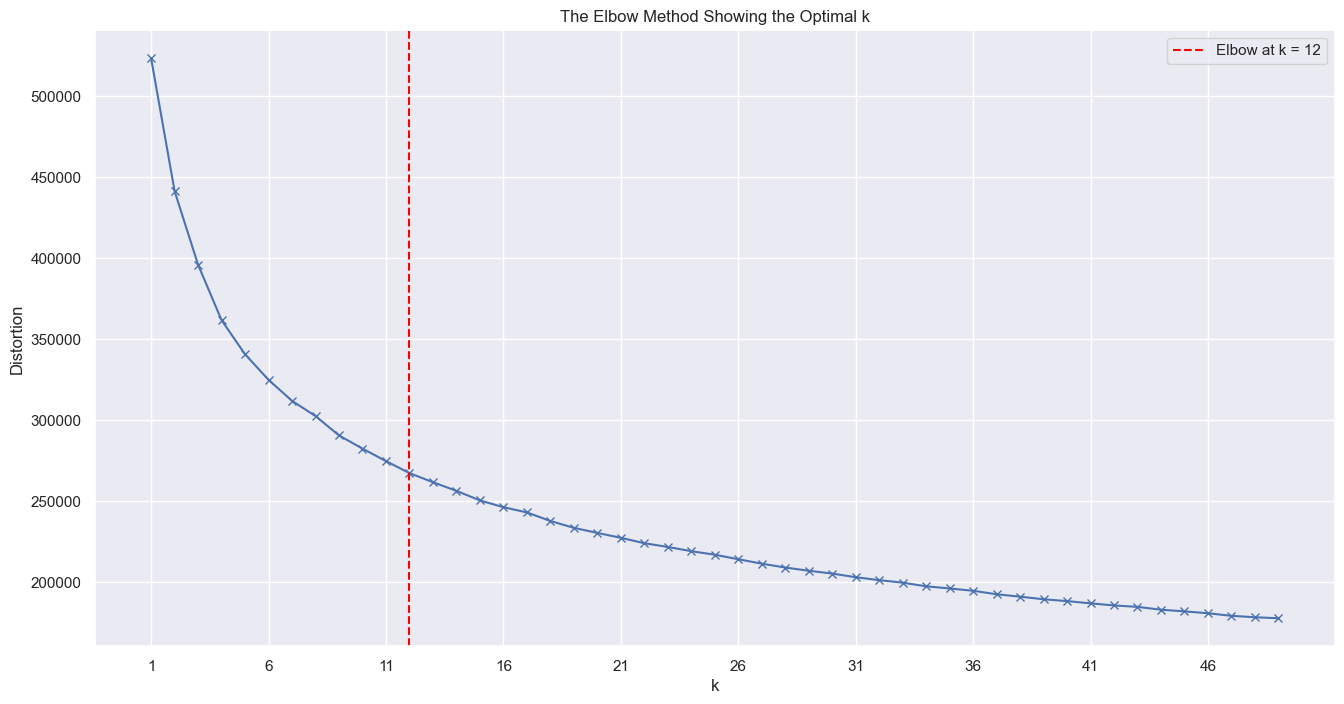

In [68]:
distortions = []
Kmax = 50
K = range(1, Kmax)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init="auto", tol=1e-4)
    kmeans.fit(data_imputed.loc[non_imputed_indices, preference_columns], sample_weight=data_imputed.loc[non_imputed_indices, 'wgt'])
    distortions.append(kmeans.inertia_)

# Detect the elbow using KneeLocator
kl = KneeLocator(K, distortions, curve='convex', direction='decreasing')
optimal_k = kl.elbow

# Plot
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, "bx-")
plt.axvline(x=optimal_k, color="red", linestyle="--", label=f"Elbow at k = {optimal_k}")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("The Elbow Method Showing the Optimal k")
plt.xticks(np.arange(1, Kmax + 1, step=5))
plt.legend()
plt.grid(True)
plt.show()


optimal k = 12 according to the elbow method, therefore we will now use k=12 to cluster the individuals.

In [69]:
# Fit again with optimal k and predict the cluster centers and print them 
kmeans = KMeans(n_clusters=optimal_k, n_init="auto", tol=1e-4)
kmeans.fit(data_imputed.loc[non_imputed_indices, preference_columns], sample_weight=data_imputed.loc[non_imputed_indices, 'wgt'])
print("Cluster centers:")
centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=preference_columns)
print("Cluster centers:")
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"Cluster {i + 1}: {dict(zip(preference_columns, center))}")
    
print("\nCluster centers as DataFrame:")
print(centers_df.round(3))

Cluster centers:
Cluster centers:
Cluster 1: {'patience': np.float64(1.9432015797263313), 'risktaking': np.float64(0.21207746915835457), 'posrecip': np.float64(0.11055909561989305), 'negrecip': np.float64(0.10965198570289054), 'altruism': np.float64(0.11109888883670507), 'trust': np.float64(0.1568897362242801), 'subj_math_skills': np.float64(0.2800799639741155)}
Cluster 2: {'patience': np.float64(-0.520509987447823), 'risktaking': np.float64(-0.655537408897543), 'posrecip': np.float64(-1.6502864910781496), 'negrecip': np.float64(-0.48825808463969456), 'altruism': np.float64(-1.134186454723666), 'trust': np.float64(-0.8244432495417796), 'subj_math_skills': np.float64(-0.9160564397946447)}
Cluster 3: {'patience': np.float64(-0.38477060990694284), 'risktaking': np.float64(-0.4998838449970895), 'posrecip': np.float64(0.2137186677492292), 'negrecip': np.float64(0.7647484136951633), 'altruism': np.float64(0.18006494090864086), 'trust': np.float64(0.4800649195691342), 'subj_math_skills': np.f

Based on the K-means clustering analysis with the optimal number of clusters (k=12), we can identify several distinct preference profiles among individuals. Here's an interpretation of the key clusters:

#### Cluster Interpretation

**High Performers (Clusters 2, 11):**
- **Cluster 2**: "Prosocial Achievers" - High prosocial traits (posrecip: 0.62, altruism: 0.71, trust: 0.71) with high math skills (0.85), but low negative reciprocity (-0.95)
- **Cluster 11**: "Balanced High Achievers" - Very high patience (1.89), high risk-taking (0.63), strong across most dimensions including math skills (0.90)

**Patient Groups (Clusters 6, 10):**
- **Cluster 6**: "Patient but Antisocial" - Extremely high patience (1.59) but negative prosocial traits (posrecip: -0.74, altruism: -0.78)
- **Cluster 10**: "Patient Prosocials" - High patience (1.73) with moderate prosocial traits, but lower math skills (-0.73)

**Risk-Taking Profiles (Clusters 4, 9):**
- **Cluster 4**: "High Risk High Reward" - Very high risk-taking (1.12) and negative reciprocity (1.11), but also high trust (0.85) and math skills (0.60)
- **Cluster 9**: "Risky but Distrustful" - High risk-taking (1.03) but very low trust (-0.92) and negative math skills (-0.57)

**Low Engagement Groups (Clusters 5, 8, 12):**
- **Cluster 5**: "Withdrawn" - Very low altruism (-1.22), low patience and risk-taking, representing disengaged individuals
- **Cluster 8**: "Negative Reciprocators" - Very low positive reciprocity (-1.38), representing individuals who don't return favors
- **Cluster 12**: "Highly Disengaged" - Negative across most dimensions, representing the most antisocial group

**Mixed Profiles (Clusters 1, 3, 7):**
- **Cluster 1**: "Conflicted" - High negative reciprocity (0.95) but moderate positive traits
- **Cluster 3**: "Low Trust Prosocials" - Moderate prosocial traits but extremely low trust (-1.21)
- **Cluster 7**: "Trusting but Incompetent" - High trust (0.74) but very low math skills (-1.20)

#### Key Insights

1. **Multidimensional Structure**: The 12 clusters confirm that human preferences are genuinely multidimensional, with distinct combinations rather than a single "good-bad" dimension.

2. **Patience-Risk Independence**: Several clusters show that patience and risk-taking can vary independently (e.g., high patience with low risk-taking in Cluster 10, high patience with moderate risk-taking in Cluster 11).

3. **Trust as Key Differentiator**: Trust levels vary dramatically across clusters (-1.21 to 0.85), often distinguishing otherwise similar preference profiles.

4. **Prosocial-Antisocial Spectrum**: Clear separation between highly prosocial clusters (2, 7, 10) and antisocial clusters (5, 8, 12).

5. **Math Skills Correlation**: Mathematical confidence tends to correlate with other positive traits but shows interesting exceptions (e.g., Cluster 6 with high patience but average math skills).

The optimal k=12 suggests that human preference diversity requires a relatively complex taxonomy to capture meaningful individual differences in behavioral tendencies, with each cluster representing a distinct "personality type" based on preferences.

#### b) Clustering Countries
Use the preference measures to cluster *countries*. <br>
Which is the optimal number of clusters? <br>
Can you provide an intuition for the clusters you identified?

In [70]:
#  Aggregate the data by country and then apply KMeans clustering again 
country_aggregated = data_imputed.loc[non_imputed_indices].groupby('country', observed=True)[preference_columns + ['wgt']].mean().reset_index()

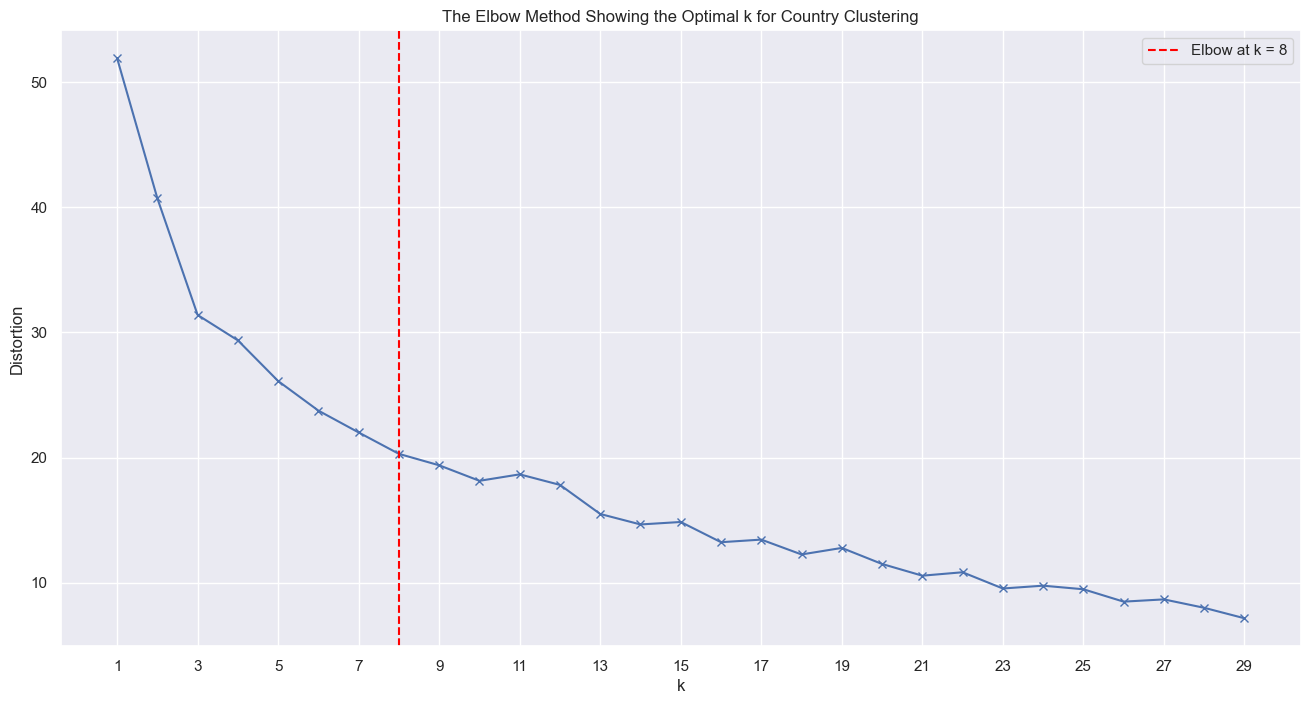

In [71]:
# Reset distortions list for country clustering
distortions_country = []
k_max = 30

for k in range(1, k_max):
    kmeans = KMeans(n_clusters=k, n_init="auto", tol=1e-4)
    kmeans.fit(country_aggregated[preference_columns], sample_weight=country_aggregated['wgt'])
    distortions_country.append(kmeans.inertia_)

# Apply KneeLocator to find the elbow
k_range = range(1, k_max)
kl_country = KneeLocator(k_range, distortions_country, curve='convex', direction='decreasing')
optimal_k_country = kl_country.elbow

# Plot with vertical line marking elbow
plt.figure(figsize=(16, 8))
plt.plot(k_range, distortions_country, "bx-")
plt.axvline(x=optimal_k_country, color="red", linestyle="--", label=f"Elbow at k = {optimal_k_country}")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("The Elbow Method Showing the Optimal k for Country Clustering")
plt.xticks(np.arange(1, k_max + 1, step=2))
plt.legend()
plt.grid(True)
plt.show()


The elbow method suggests the optimal number of clusters is k=7, so we will use k=7 to cluster the countries.

In [72]:
# Fit K-means with optimal k for country clustering using country-aggregated data
kmeans_country = KMeans(n_clusters=optimal_k_country, n_init="auto", tol=1e-4)
kmeans_country.fit(country_aggregated[preference_columns], sample_weight=country_aggregated['wgt'])

print("Country Cluster Centers:")
centers_df_country = pd.DataFrame(kmeans_country.cluster_centers_, columns=preference_columns)

print("Country cluster centers:")
for i, center in enumerate(kmeans_country.cluster_centers_):
    print(f"Cluster {i + 1}: {dict(zip(preference_columns, center))}")
    
print("\nCountry cluster centers as DataFrame:")
print(centers_df_country.round(3))

# Show which countries belong to each cluster
country_aggregated['cluster'] = kmeans_country.labels_
print("\nCountries by cluster:")
for i in range(optimal_k_country):
    countries_in_cluster = country_aggregated[country_aggregated['cluster'] == i]['country'].tolist()
    print(f"Cluster {i + 1}: {countries_in_cluster}")

Country Cluster Centers:
Country cluster centers:
Cluster 1: {'patience': np.float64(-0.39988780896872483), 'risktaking': np.float64(-0.41681888052818405), 'posrecip': np.float64(-0.0836096984263308), 'negrecip': np.float64(-0.29996183488646533), 'altruism': np.float64(-0.1029959144166958), 'trust': np.float64(0.0946267005866389), 'subj_math_skills': np.float64(0.056162791238511256)}
Cluster 2: {'patience': np.float64(-0.06101482635300231), 'risktaking': np.float64(0.04976422219712376), 'posrecip': np.float64(0.31520222685148425), 'negrecip': np.float64(0.09196552148054533), 'altruism': np.float64(0.4450113939103142), 'trust': np.float64(0.27824673415956086), 'subj_math_skills': np.float64(0.005124008125896746)}
Cluster 3: {'patience': np.float64(-0.011010387300894984), 'risktaking': np.float64(-0.16818134957910044), 'posrecip': np.float64(-0.5159174480079448), 'negrecip': np.float64(0.05285232423427431), 'altruism': np.float64(-0.5826117684801733), 'trust': np.float64(-0.2488794757945


##### Cluster Profiles

**Cluster 1: "Resource-Rich Risk-Taking Nations"** (11 countries)
- **Profile**: High risk-taking (0.561), low prosocial traits (posrecip: -0.343, altruism: -0.156), low trust (-0.252)
- **Countries**: Algeria, Botswana, Ghana, Kenya, Malawi, Nigeria, Saudi Arabia, South Africa, Tanzania, Uganda, Zimbabwe
- **Interpretation**: Mix of African nations and oil-rich countries with competitive economic environments and individualistic orientations

**Cluster 2: "Traditional High-Trust Societies"** (14 countries)
- **Profile**: High prosocial traits (posrecip: 0.253, altruism: 0.313), strong trust (0.233), moderate negative reciprocity (0.197)
- **Countries**: Afghanistan, Bangladesh, China, Egypt, Indonesia, Iran, Italy, Moldova, Philippines, South Korea, Spain, Suriname, Thailand, UAE
- **Interpretation**: Diverse mix emphasizing social cohesion, traditional values, and cooperative behavior across different development levels

**Cluster 3: "Emerging Market Moderates"** (20 countries)
- **Profile**: Low patience (-0.241), risk-averse (-0.147), moderate cooperation (posrecip: 0.207), low punishment (negrecip: -0.261)
- **Countries**: Argentina, Bolivia, Brazil, Cambodia, Cameroon, Chile, Colombia, Costa Rica, Georgia, Guatemala, Jordan, Kazakhstan, Morocco, Portugal, Romania, Russia, Serbia, Sri Lanka, Ukraine, Venezuela
- **Interpretation**: Transitional economies and developing nations with cautious but cooperative approaches

**Cluster 4: "Low-Development Constrained Societies"** (3 countries)
- **Profile**: Very low patience (-0.577), very risk-averse (-0.458), low cooperation across all dimensions
- **Countries**: Hungary, Nicaragua, Rwanda
- **Interpretation**: Countries with significant economic or historical constraints limiting long-term planning and risk-taking

**Cluster 5: "Developed Western Nations"** (11 countries)
- **Profile**: High patience (0.749), moderate cooperation, highest subjective math skills (0.336), strong trust (0.192)
- **Countries**: Australia, Austria, Canada, Finland, Germany, Israel, Netherlands, Sweden, Switzerland, UK, USA
- **Interpretation**: Wealthy developed countries with strong institutions, characterized by long-term thinking and educational confidence

**Cluster 6: "Post-Transition Low-Cooperation States"** (5 countries)
- **Profile**: Very low positive reciprocity (-0.599), very low altruism (-0.728), low trust (-0.206)
- **Countries**: Czech Republic, Estonia, Haiti, Lithuania, Mexico
- **Interpretation**: Countries showing individualistic tendencies, possibly reflecting post-transition or development challenges

**Cluster 7: "Mixed Development Moderate Societies"** (11 countries)
- **Profile**: Moderate negative reciprocity (0.255), balanced across other dimensions with slight negative tendencies
- **Countries**: Bosnia Herzegovina, France, Greece, India, Iraq, Japan, Pakistan, Peru, Poland, Turkey, Vietnam
- **Interpretation**: Diverse group spanning different development levels with balanced but somewhat guarded social orientations

#### Key Insights

1. **Development-Preference Link**: Clear separation between developed nations (Cluster 5) showing high patience and math confidence versus constrained societies (Cluster 4) with limited planning horizons.

2. **Cultural Dimensions**: Traditional societies (Cluster 2) emphasize cooperation and trust, while resource-rich nations (Cluster 1) show more competitive, individualistic patterns.

3. **Geographic Clustering**: Strong regional patterns emerge, particularly for developed Western nations, African countries, and post-communist states.

4. **Post-Transition Effects**: Eastern European countries show varied patterns, suggesting different adaptation strategies to economic transition.

5. **Resource-Cooperation Trade-off**: Resource-rich nations tend toward lower cooperation and higher risk-taking, potentially reflecting competitive economic structures.

The 7-cluster solution effectively captures the complex interplay between economic development, cultural values, institutional quality, and geographic proximity in shaping national preference profiles.
